<a href="https://colab.research.google.com/github/rayramadharcs102/Ray-Ramadhar-Portfolio/blob/main/Data_Driven_Problem_Solving_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Classifying HVAC Operational Modes Based on Heating and Cooling Energies
## ME 371: Data-Driven Problem Solving
## Fall 2025

**Name(s)**: Ray Ramadhar

**Date**: December 19, 2025

**Dataset**: A synthetic building operation dataset(Nature Scientific Data)

###1: Introduction and Problem Statement

The objective of this project is to develop ML models that classify a building's operational HVAC mode—Heating, Cooling, or Neutral based on measured energy consumption, environmental conditions, and operational variables. This is based off synthetic data. This is a multi-class classification problem, with 3 classes where the target variable is an engineered operational_mode.

This is important because it can help with energy efficiency analysis which can help with energy optimization strategies, especially as energy efficiency becomes more and more important in the modern era. This can also help with detecting energy inefficient systems as well as predictive control. Work in this area can also help older and new buildings alike with looking at there building energy consumption.

The dataset used in this project is the Building Energy Database, a synthetic building operation dataset published in Nature Scientific Data. Miller, C., et al. The Building Energy Dataset: A large-scale synthetic dataset of building operation. Nature Scientific Data. The dataset contains hourly building operation data, including HVAC energy usage, environmental conditions, and occupancy-related variables.

The size of the dataset is 52560x20 rows by columns, and 14 features were intially used but it was then condensed for both the LR, and KNN models. The features that were of no use to the Decision Tree were also removed after analysis.

The limitations were with the class distribution mostly, and the definition of the Neutral Class. Since the neutral class is only about 10% of the data witht he cooling overpowering at around 70% the datest was initially imbalanced. THe decision tree worked well with the imbalanced data generally (macro) and across all 3 classifications with metrics above 0.75 and above 0.8 with more depth.

The LR and KNN models worked well with macro metric, but struggled significantly with neutral classification with metrics falling below 0.6 often. After balancing the data and tuning and the overalll performances increased slightly for KNN and LR but what was most important was the neutral classification. The Logistic Regression did not get above 0.62 across metrics likely do to the multiclass state of the problem, which it struggled with. The KNN model improved significantly across metrics in neutral classification indicating the importance of stratifying data.

###2: Data Loading and Overview

### 2.1: Libraries Used

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import cv2  # Install using: pip install opencv-python

# Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import math

# Traditional ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

# Handling imbalanced Data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Evaluation metrics
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report,
                             precision_score, recall_score, log_loss)
# Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Fold and Grid Search
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


###2.2: Setting the base path to data folder

In [ ]:
BASE_PATH =  '/content/drive/MyDrive/ME-371 Notebooks'
zip_path = f"{BASE_PATH}/Dataset_II.zip"

###2.3: Understanding the Data

In [ ]:
import zipfile
# Here I am extracting the zip file from the base path. I needed to use AI for the bugs.
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(BASE_PATH)

pkl_path = f"{BASE_PATH}/df_reduced.pkl"
df = pd.read_pickle(pkl_path)

# Basic Evaluation of statistics and shape
# display(df.head(20))
df.shape

(52560, 20)

#3: Data Preprocessing Part 1 (Cleaning, Outlier Search, Target Engineering)

###3.1: Defining Features

In [ ]:
# 1. Move the index (containing the dates) into a column named 'timestamp'
df = df.reset_index().rename(columns={'index': 'timestamp'})

# 2. Ensure it is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract features
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['year'] = df['timestamp'].dt.year

# Environmental Features
env_features = [
    'Environment:Site Outdoor Air Drybulb Temperature[C]',
    'Environment:Site Outdoor Air Wetbulb Temperature[C]',
    'Environment:Site Outdoor Air Dewpoint Temperature[C]',
    'Environment:Site Outdoor Air Relative Humidity[%]'
]

# Internal Building Features
internal_load_features = [
    'InteriorLights:Electricity[J]',
    'InteriorEquipment:Electricity[J]',
    'ExteriorLights:Electricity[J]'
]

# Indicators of Mechanical Performance Features
mechanical_features = [
    '21 ZONE PVAV 1 FAN:Fan Electric Power[W]',
    '21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]',
    'MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W]',
    'MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Mass Flow Rate[kg/s]'
]

# Time Features
time_features = [
    'hour',
    'weekday',
    'month'
]

features = (env_features +
internal_load_features +
mechanical_features +
time_features)



For the following models the columns,
    'Heating:Electricity[J]',
    'Cooling:Electricity[J]',
    'Gas:HVAC[J]',
    'Electricity:HVAC[J]',
    'Electricity:Facility[J]',
    'heating_energy',
    'cooling_energy',
    'efficiency'
will not be used as it can cause artificially high accuracy, F1-score etc. because of data leakage and these data aggregates and indicators will not provide a true model.

### 3.2: Looking for Missing Values and Cleaning Data

In [ ]:
# Defining Features Together
X = df[features]

# Looking for null values in dataset features
print('Checking null sums for before dropping for major energy users:\n')
display(X.isnull().sum())

## Now, descriptive statistics can be done on these dataframes
print('For D:')
print("a)First 5 rows:")
display(X.head())
print(f'\nShape: \n{X.shape}')
print(f'\nColumns:\n{X.columns.tolist()}')
print(f'\nData Types:\n{X.dtypes}')
print(f'\nDescription of Data: \n{X.describe()}\n')

Checking null sums for before dropping for major energy users:



,0
Environment:Site Outdoor Air Drybulb Temperature[C],0
Environment:Site Outdoor Air Wetbulb Temperature[C],0
Environment:Site Outdoor Air Dewpoint Temperature[C],0
Environment:Site Outdoor Air Relative Humidity[%],0
InteriorLights:Electricity[J],0
InteriorEquipment:Electricity[J],0
ExteriorLights:Electricity[J],0
21 ZONE PVAV 1 FAN:Fan Electric Power[W],0
21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s],0
MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W],0


For D:
a)First 5 rows:


,Environment:Site Outdoor Air Drybulb Temperature[C],Environment:Site Outdoor Air Wetbulb Temperature[C],Environment:Site Outdoor Air Dewpoint Temperature[C],Environment:Site Outdoor Air Relative Humidity[%],InteriorLights:Electricity[J],InteriorEquipment:Electricity[J],ExteriorLights:Electricity[J],21 ZONE PVAV 1 FAN:Fan Electric Power[W],21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s],MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W],MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Mass Flow Rate[kg/s],hour,weekday,month
0,11.966667,7.693049,3.15,55.000000,3.056824e+06,1.011649e+07,3140109.0,0.0,0.0,0.0,0.0,0,0,1
1,7.700000,4.175716,-0.40,56.333333,3.056824e+06,1.011649e+07,3140109.0,0.0,0.0,0.0,0.0,1,0,1
2,7.200000,4.254720,0.50,62.500000,3.056824e+06,1.011649e+07,3140109.0,0.0,0.0,0.0,0.0,2,0,1
3,7.116667,3.961751,-0.10,59.833333,3.056824e+06,1.011649e+07,3140109.0,0.0,0.0,0.0,0.0,3,0,1
4,6.700000,3.570367,-0.50,59.500000,3.056824e+06,1.011649e+07,3140109.0,0.0,0.0,0.0,0.0,4,0,1



Shape: 
(52560, 14)

Columns:
['Environment:Site Outdoor Air Drybulb Temperature[C]', 'Environment:Site Outdoor Air Wetbulb Temperature[C]', 'Environment:Site Outdoor Air Dewpoint Temperature[C]', 'Environment:Site Outdoor Air Relative Humidity[%]', 'InteriorLights:Electricity[J]', 'InteriorEquipment:Electricity[J]', 'ExteriorLights:Electricity[J]', '21 ZONE PVAV 1 FAN:Fan Electric Power[W]', '21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]', 'MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W]', 'MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Mass Flow Rate[kg/s]', 'hour', 'weekday', 'month']

Data Types:
Environment:Site Outdoor Air Drybulb Temperature[C]                  float64
Environment:Site Outdoor Air Wetbulb Temperature[C]                  float64
Environment:Site Outdoor Air Dewpoint Temperature[C]                 float64
Environment:Site Outdoor Air Relative Humidity[%]                    float64
InteriorLights:Electricity[J]                                       

This is a good sign as the there is no missing data values, therefore no cleaning in terms of missing values is needed for these columns. Next, a check for outliers will be done. Looking at the descriptive statistics there is no severe outliers in the chosen features.

### 3.3: Engineering the Operational Mode Target

In [ ]:
# Defining Thresholds
HEATING_THRESHOLD = 2e5
COOLING_ACTIVE_THRESHOLD = 1e7
df['heating_energy'] = (df['Gas:Facility[J]'] + df['Heating:Electricity[J]'])
df['cooling_energy'] = df['Cooling:Electricity[J]']
df['operational_mode'] = 'Neutral'

# Heating mode
heating_mask = (
    (df['heating_energy'] >= HEATING_THRESHOLD) &
    (df['heating_energy'] >= df['cooling_energy'])
)
df.loc[heating_mask, 'operational_mode'] = 'Heating'

# Cooling mode
cooling_mask = (
    (df['cooling_energy'] >= COOLING_ACTIVE_THRESHOLD) &
    (df['cooling_energy'] >= df['heating_energy'])
)
df.loc[cooling_mask, 'operational_mode'] = 'Cooling'

print(df['operational_mode'].value_counts())

y = df['operational_mode']



operational_mode
Cooling    36182
Heating    11143
Neutral     5235
Name: count, dtype: int64


Looking at the describe statistics of the energy components I made a thresholdto determine whether the bulding was in a heating, neutral, or cooling mode. I predict that the cooling mode will be the largest since the cooling energy is on average a magnitude of 2 higher than the average energy needed for heating. I made the threshold a bit lower than the mean, and enforced that if the heating was above the threshold, which was near the mean, and cooling wasn't above it's threshold, which was also in the same magnitude as its mean, then it was a heating mode, and vice versa. If both were above then the highest value would be taken, and that would be the mode. If both were below, then the neutral class was introduced. *From the value counts I can tell that there is imbalance, and found later that the neutral classification would be hardest to achieve reasonable values in.


#4: Exploratory Data Analysis

###4.1: Analyzing Class Distribution Within Engineered Target


Class Distribution:
operational_mode
Cooling    36182
Heating    11143
Neutral     5235
Name: count, dtype: int64

Class Distribution (Percentage):
operational_mode
Cooling    68.839422
Heating    21.200533
Neutral     9.960046
Name: proportion, dtype: float64


/tmp/ipython-input-1210899872.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Heating','Neutral', 'Cooling'])


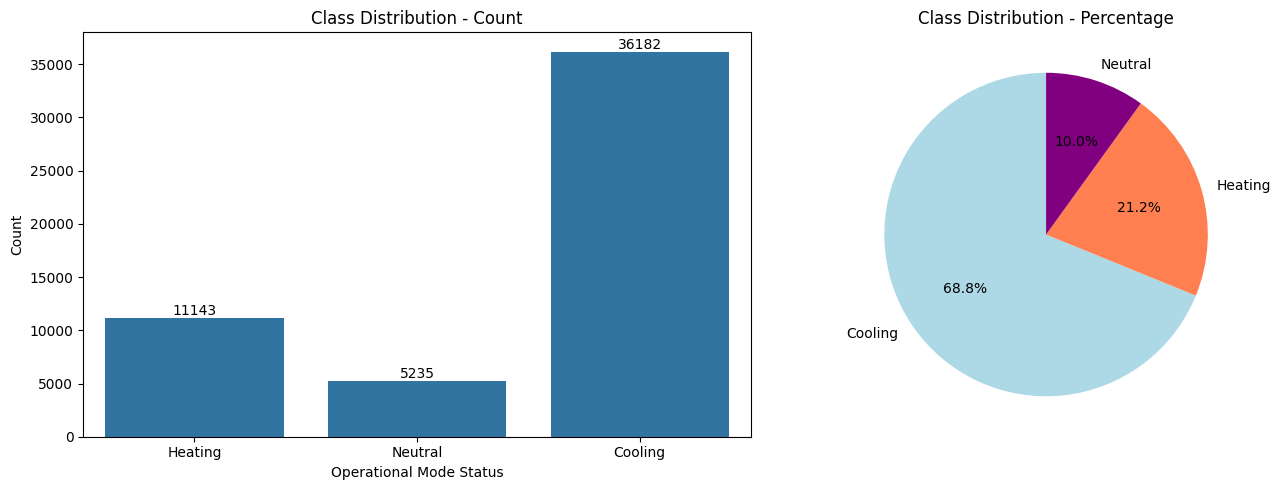

(52560, 28)

In [ ]:
# Checking the Class Distribution
print("\nClass Distribution:")
print(df['operational_mode'].value_counts())

print("\nClass Distribution (Percentage):")
print(df['operational_mode'].value_counts(normalize=True)*100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class Distrbution Chart
sns.countplot(data=df, x = 'operational_mode', ax = axes[0])
axes[0].set_title('Class Distribution - Count')
axes[0].set_xlabel('Operational Mode Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Heating','Neutral', 'Cooling'])

# Adding labels to the count plots on bars
for container in axes[0].containers:
  axes[0].bar_label(container)

# Pie Chart
efficiency_counts = df['operational_mode'].value_counts()
axes[1].pie(efficiency_counts, labels = ['Cooling', 'Heating', 'Neutral' ],\
            autopct='%1.1f%%', startangle = 90, colors=['lightblue', 'coral', 'purple'] )
axes[1].set_title('Class Distribution - Percentage')

plt.tight_layout()
plt.show()

# Shape of the Dataset
df.shape


This graph visually shows the imbalance, which is workable, but definitely dominated by cooling, which, at least for the LR and KNN model, will need some resampling and optimizing.

###4.2: Feature types (numerical, categorical)

In [ ]:
# Creates a summary of types and unique counts
type_summary = pd.DataFrame({
    'Data Type': X.dtypes,
    'Unique Values': X.nunique(),
    'Sample Value': X.iloc[0]
})
print(type_summary)

                                                   Data Type  Unique Values  \
Environment:Site Outdoor Air Drybulb Temperatur...   float64            684   
Environment:Site Outdoor Air Wetbulb Temperatur...   float64          17377   
Environment:Site Outdoor Air Dewpoint Temperatu...   float64            945   
Environment:Site Outdoor Air Relative Humidity[%]    float64            655   
InteriorLights:Electricity[J]                        float64           2220   
InteriorEquipment:Electricity[J]                     float64          15132   
ExteriorLights:Electricity[J]                        float64              3   
21 ZONE PVAV 1 FAN:Fan Electric Power[W]             float64          38472   
21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]      float64          38474   
MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump El...   float64              9   
MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Ma...   float64              4   
hour                                                

This shows that all the selected features are numerical.

###4.3: Analyzing the Pump energy usage over time something over time compared to years split dataset by year groupby hour


Energy used from Pump, Gas, Interior Equipment, and Fans per vs hour Plot:


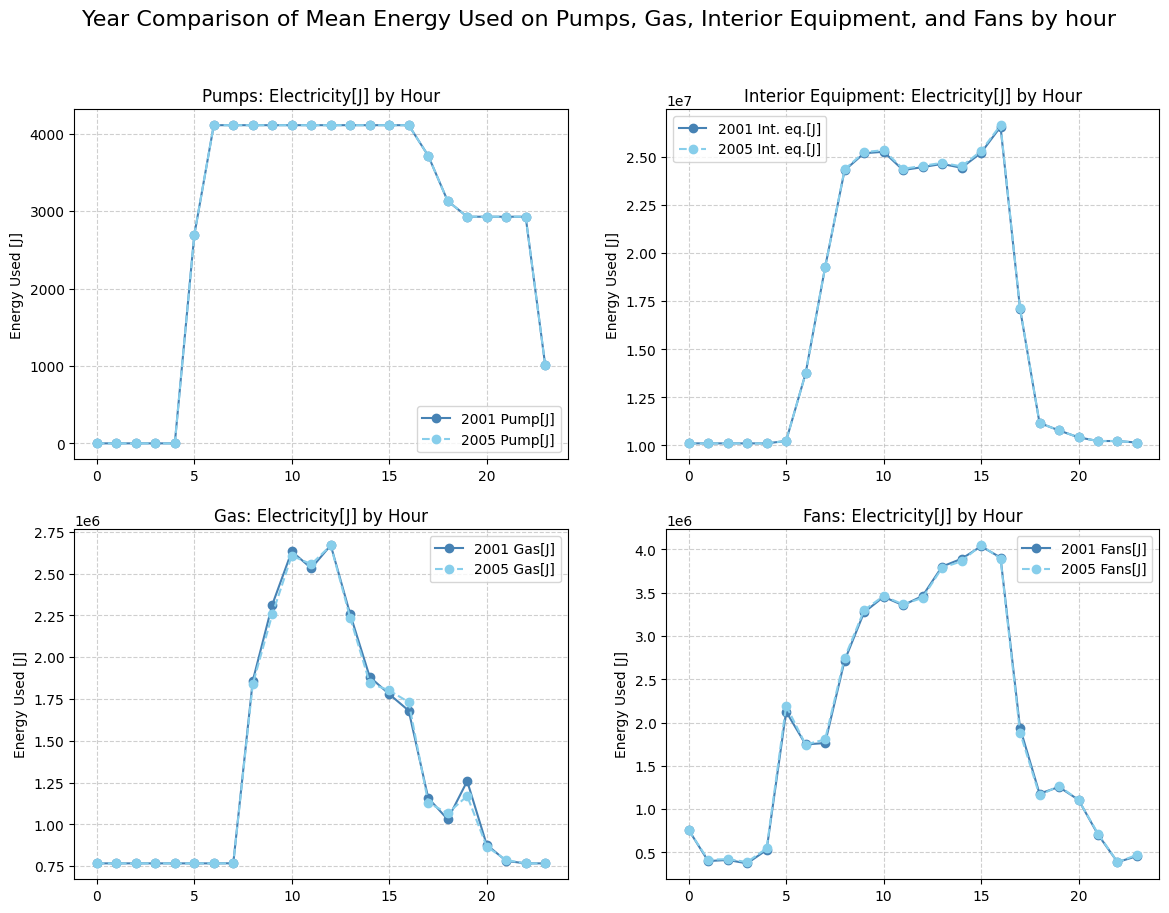

In [ ]:
# Splitting the data by year
df_2001 = df[df['year'] == 2001]
df_2005 = df[df['year'] == 2005]

mean_energy_2001 = df_2001.groupby('hour')[['Pumps:Electricity[J]',
                                            'Gas:Facility[J]',
                                            'InteriorEquipment:Electricity[J]',
                                            'Fans:Electricity[J]']].mean()

mean_energy_2005 = df_2005.groupby('hour')[['Pumps:Electricity[J]',
                                            'Gas:Facility[J]',
                                            'InteriorEquipment:Electricity[J]',
                                            'Fans:Electricity[J]']].mean()


print('\nEnergy used from Pump, Gas, Interior Equipment, and Fans per vs hour Plot:')
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Year Comparison of Mean Energy Used on Pumps, Gas, Interior Equipment, and Fans by hour', fontsize=16)

# Plot 1: Pumps
ax[0, 0].plot(mean_energy_2001.index, mean_energy_2001['Pumps:Electricity[J]'],
              marker='o', linestyle='-', color='steelblue', label='2001 Pump[J]')
ax[0, 0].plot(mean_energy_2005.index, mean_energy_2005['Pumps:Electricity[J]'],
              marker='o', linestyle='--', color='skyblue', label='2005 Pump[J]')
ax[0, 0].set_title('Pumps: Electricity[J] by Hour')
ax[0, 0].set_ylabel('Energy Used [J]')
ax[0, 0].grid(True, linestyle='--', alpha=0.6)
ax[0, 0].legend()

# Plot 2: Gas
ax[1, 0].plot(mean_energy_2001.index, mean_energy_2001['Gas:Facility[J]'],
              marker='o', linestyle='-', color='steelblue', label='2001 Gas[J]')
ax[1, 0].plot(mean_energy_2005.index, mean_energy_2005['Gas:Facility[J]'],
              marker='o', linestyle='--', color='skyblue', label='2005 Gas[J]')
ax[1, 0].set_title('Gas: Electricity[J] by Hour')
ax[1, 0].set_ylabel('Energy Used [J]')
ax[1, 0].grid(True, linestyle='--', alpha=0.6)
ax[1, 0].legend()

# Plot 3: Interior Equipment
ax[0, 1].plot(mean_energy_2001.index, mean_energy_2001['InteriorEquipment:Electricity[J]'],
              marker='o', linestyle='-', color='steelblue', label='2001 Int. eq.[J]')
ax[0, 1].plot(mean_energy_2005.index, mean_energy_2005['InteriorEquipment:Electricity[J]'],
              marker='o', linestyle='--', color='skyblue', label='2005 Int. eq.[J]')
ax[0, 1].set_title('Interior Equipment: Electricity[J] by Hour')
ax[0, 1].set_ylabel('Energy Used [J]')
ax[0, 1].grid(True, linestyle='--', alpha=0.6)
ax[0, 1].legend()

ax[1, 1].plot(mean_energy_2001.index, mean_energy_2001['Fans:Electricity[J]'],
              marker='o', linestyle='-', color='steelblue', label='2001 Fans[J]')
ax[1, 1].plot(mean_energy_2005.index, mean_energy_2005['Fans:Electricity[J]'],
              marker='o', linestyle='--', color='skyblue', label='2005 Fans[J]')
ax[1, 1].set_title('Fans: Electricity[J] by Hour')
ax[1, 1].set_ylabel('Energy Used [J]')
ax[1, 1].grid(True, linestyle='--', alpha=0.6)
ax[1, 1].legend()
plt.show()


These plots demonstrate that major amounts of energy use do not vary over year but they do vary over hour of the day. This indicates that year is likely a useless feature for the models and will eventually be removed. Hour is also likely an important feature for training, with good importance.

###4.4: Target Distribution

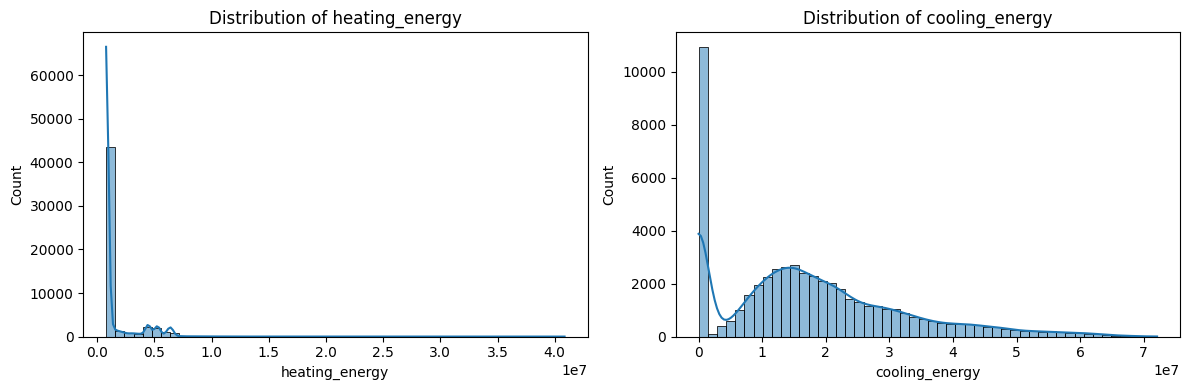

In [ ]:
targets_to_plot = [
    'heating_energy',
    'cooling_energy',
]

plt.figure(figsize=(12,4))
for i, feature in enumerate(targets_to_plot, 1):
    plt.subplot(1, len(targets_to_plot), i)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
plt.tight_layout()
plt.show()


This shows an overwhelming amount of values at 0 for both heating and cooling. This may cause some noise however, despite technically being accurate. There doesn't seem to be a major outlier as most of the class lays in a succinct area, with a high saturation at 0. Therefore, no values will be removed, as this is representative of the true dataset.

###4.6: Correlation Heatmap of Main Model Features

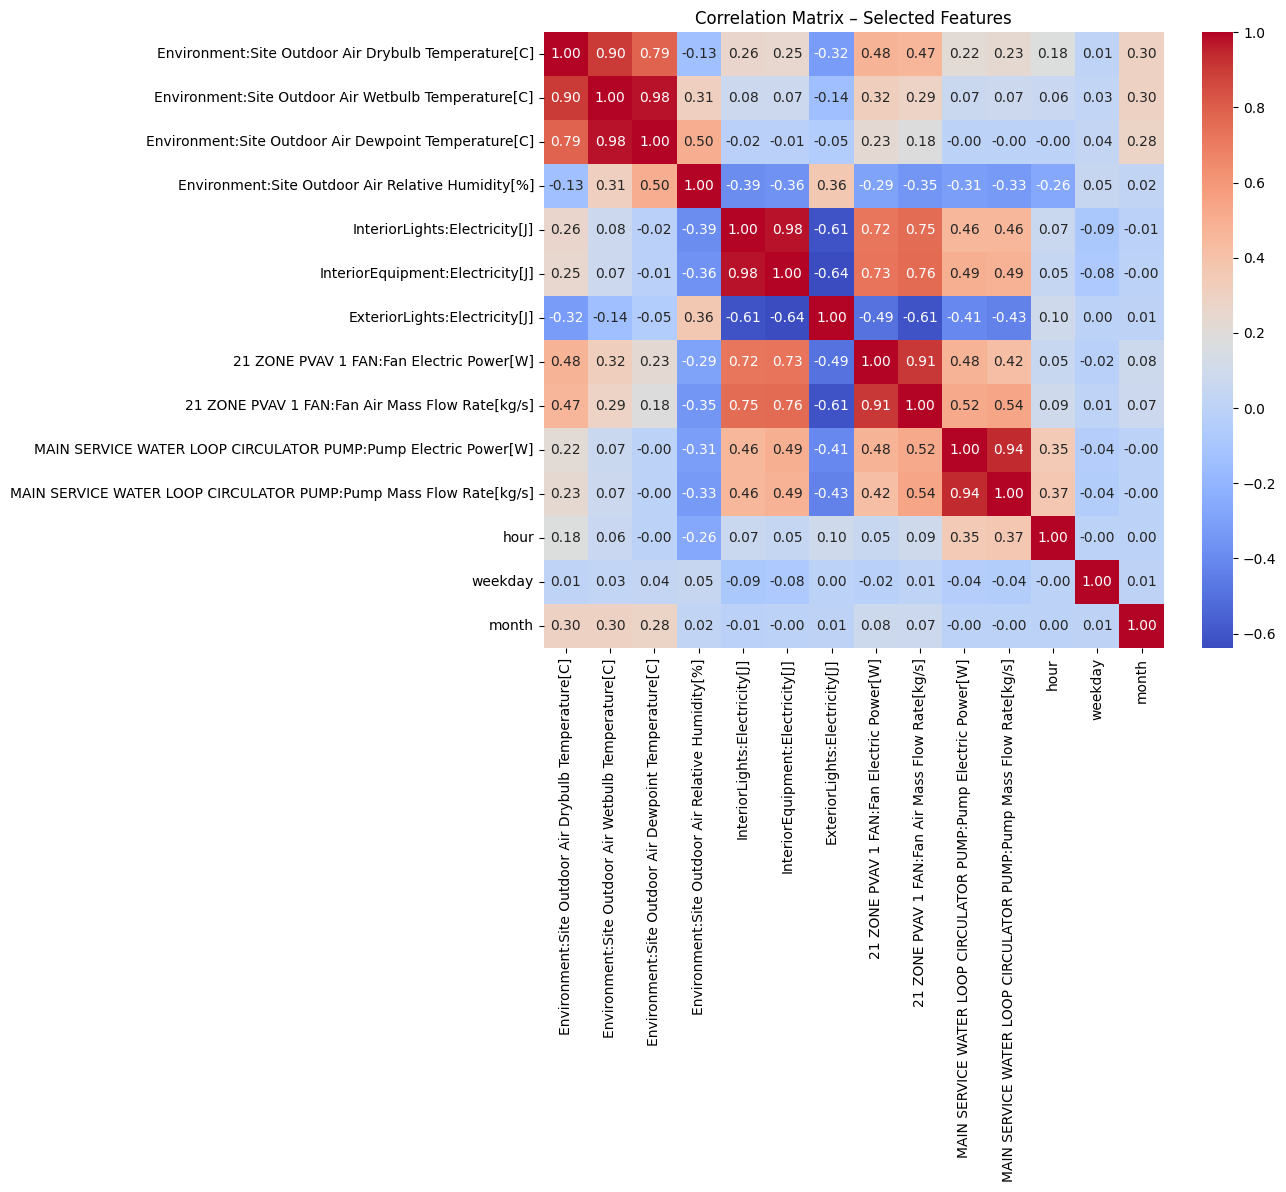

In [ ]:
#Correlation Heatmap on Features
corr = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix – Selected Features")
plt.show()

These features were looked at specifically as the efficiency is measured based off of the gas burner efficiency, fan total efficiency, pump motor efficiency. This data displays that the energy usage and efficiency is likeyl the same in both 2001 and 2005. This means no adidtional control systems or BMS updates were done on the building or updated. This also demonstrated that the controllers that actuate the energy usage, since a lot of the energy usage is used from the hours 5 AM -> 5 PM about. This means these industrial fans, pumps etc. are being controlled so they only operate during the workday which save on energy as the efficiency will likely go up with less energy used.

#5: Model Development

###5.1: Model 1: Logistic Regression

In [ ]:
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Create MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Verify normalization (all values should be between 0 and 1)
print(f"Min value after scaling: {X_scaled.min()}")
print(f"Max value after scaling: {X_scaled.max()}")

# Split data: 70% training, 30% testing
from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y, test_size = 0.2, random_state= 42
)

y_traindf = pd.DataFrame(y_train_lr)

print(f"Training set size: {X_train_lr.shape[0]}")
print(f"Test set size: {X_test_lr.shape[0]}")
print(f"Training set class distribution:\n{y_traindf.value_counts()}")

Feature matrix shape: (52560, 14)
Target vector shape: (52560,)
Min value after scaling: 0.0
Max value after scaling: 1.0
Training set size: 42048
Test set size: 10512
Training set class distribution:
operational_mode
Cooling             28942
Heating              8872
Neutral              4234
Name: count, dtype: int64


A min max scaler was used for the LR since this is it gives best results when outliers are minimal or absent as it is sensitive to extreme values. This is assuming that the high 0 concentration does not affect the data too much. A test size of 0.2 was used for this model.

###5.1a: Building a Logistic Regression Model

In [ ]:
# Create Logistic Regression classifier
lr = LogisticRegression(
    multi_class='multinomial',   # true multiclass softmax
    solver='lbfgs',              # required for multinomial
    max_iter=1000,
    class_weight=None,           # baseline
    random_state=42)

# Train the model
lr.fit(X_train_lr, y_train_lr)

# Make predictions on both training and test sets
y_train_pred_lr = lr.predict(X_train_lr)
y_test_pred_lr = lr.predict(X_test_lr)


# Get probability predictions
y_test_pred_proba_lr = lr.predict_proba(X_test_lr)

print("Logistic Regression model trained successfully!")
print(f"Classes: {lr.classes_}")

# Display first 10 probability predictions
y_test_df = pd.DataFrame(y_test_lr)
print("Sample probability predictions (first 10):")
print("Format: [P(class=0), P(class=1)], P(class=2)]")

for i in range(10):
  actual = y_test_df.iloc[i]
  predicted = y_test_pred_lr[i]
  proba = y_test_pred_proba_lr[i]
  print(f"Sample {i}: Actual={actual}, Predicted={predicted}, "
          f"Probabilities={proba[0]:.3f}, {proba[1]:.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression model trained successfully!
Classes: ['Cooling' 'Heating' 'Neutral']
Sample probability predictions (first 10):
Format: [P(class=0), P(class=1)], P(class=2)]
Sample 0: Actual=operational_mode    Heating
Name: 44380, dtype: object, Predicted=Heating, Probabilities=0.000, 0.814
Sample 1: Actual=operational_mode    Cooling
Name: 20192, dtype: object, Predicted=Cooling, Probabilities=0.769, 0.005
Sample 2: Actual=operational_mode    Cooling
Name: 4070, dtype: object, Predicted=Cooling, Probabilities=1.000, 0.000
Sample 3: Actual=operational_mode    Cooling
Name: 26848, dtype: object, Predicted=Cooling, Probabilities=0.999, 0.000
Sample 4: Actual=operational_mode    Cooling
Name: 48569, dtype: object, Predicted=Cooling, Probabilities=0.915, 0.001
Sample 5: Actual=operational_mode    Neutral
Name: 46411, dtype: object, Predicted=Neutral, Probabilities=0.217, 0.103
Sample 6: Actual=operational_mode    Cooling
Name: 31233, dtype: object, Predicted=Cooling, Probabilities=1.0

Currently the model seems to be predicting correctly, but this may be due to the high ocncentration of cooling classifications which dominate.

###5.1c: Evaluate Logistic Regression Model

In [ ]:
# Calculate metrics for training set
acc_train_lr = accuracy_score(y_train_lr, y_train_pred_lr)
f1_train_lr = f1_score(y_train_lr, y_train_pred_lr, average='macro')
precision_lr_train = precision_score(y_train_lr, y_train_pred_lr, average='macro')
recall_lr_train = recall_score(y_train_lr, y_train_pred_lr, average='macro')

print("\n" + "="*50 + "\n")

# Calculate metrics for test set
acc_test_lr = accuracy_score(y_test_lr, y_test_pred_lr)
f1_test_lr = f1_score(y_test_lr, y_test_pred_lr, average='macro')
precision_lr_test = precision_score(y_test_lr, y_test_pred_lr, average='macro')
recall_lr_test = recall_score(y_test_lr, y_test_pred_lr,average='macro')

print("Logistic Regression Test Set Performance:")
print(f"Accuracy:  {acc_test_lr:.3f}")
print(f"F1-Score:  {f1_test_lr:.3f}")
print(f"Precision:  {precision_lr_test:.3f}")
print(f"Recall:  {recall_lr_test:.3f}")

print("Logistic Regression Train Set Performance:")
print(f"Accuracy:  {acc_train_lr:.3f}")
print(f"F1-Score:  {f1_train_lr:.3f}")
print(f"Precision:  {precision_lr_train:.3f}")
print(f"Recall:  {recall_lr_train:.3f}")


print(classification_report(y_test_lr, y_test_pred_lr))




Logistic Regression Test Set Performance:
Accuracy:  0.929
F1-Score:  0.810
Precision:  0.858
Recall:  0.793
Logistic Regression Train Set Performance:
Accuracy:  0.929
F1-Score:  0.816
Precision:  0.866
Recall:  0.800
              precision    recall  f1-score   support

     Cooling       0.96      0.98      0.97      7240
     Heating       0.88      0.99      0.93      2271
     Neutral       0.73      0.41      0.53      1001

    accuracy                           0.93     10512
   macro avg       0.86      0.79      0.81     10512
weighted avg       0.92      0.93      0.92     10512



These initial metrics of the Logistics Regression Model demonstrate exactly what was learned in class. Due to the high class imbalance with cooling vs heating and neutral, there was seemingly no issues when weighted average was used. The scores were all above 0.9 which did not seem an accurate representation and which did not exhibit what I expected without class balance. After switching to macro, which is good for multi-class classification problems where class distributions can be skewed, there was a noticable drop in recall and F1 score. The classification report showed high detection and goodperormance with cooling but these metrics dropped substantially for neutral, indicating the need for class balance.

###5.1d: Confusion Matrix for LR

Confusion Matrix (Test Set):
[[7113    1  126]
 [   5 2240   26]
 [ 296  294  411]]

Confusion Matrix (Train Set):
[[28475     7   460]
 [   22  8752    98]
 [ 1122  1291  1821]]


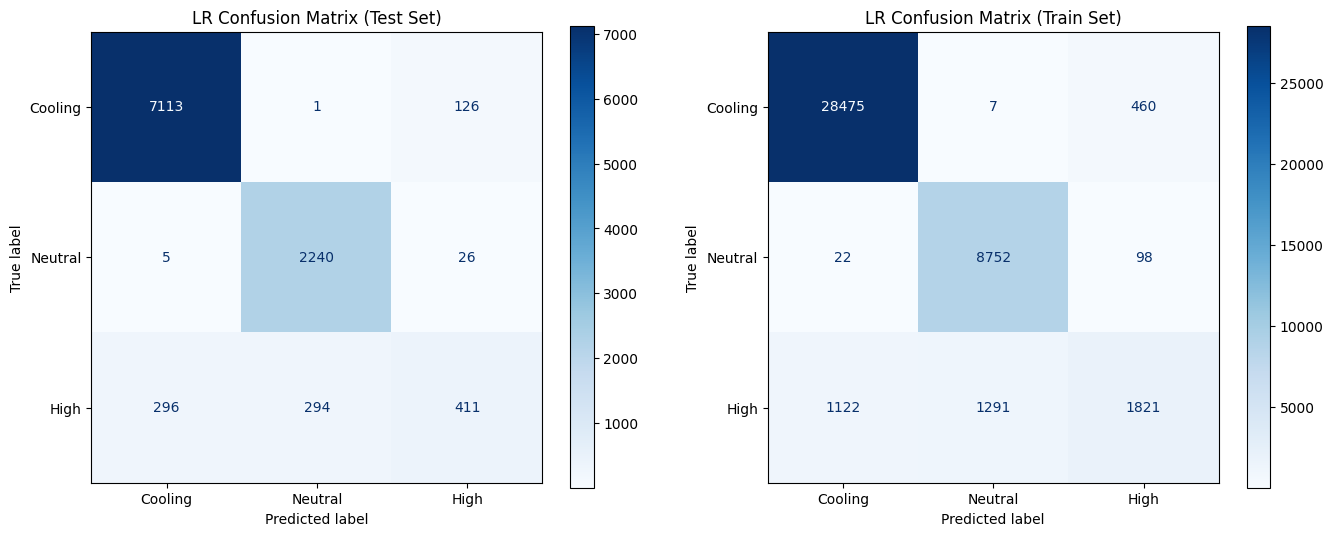

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Create confusion matrix for test set
cm_lr_test = confusion_matrix(y_test_lr, y_test_pred_lr)

# Display confusion matrix for test set
disp_lr_test = ConfusionMatrixDisplay(cm_lr_test, display_labels = ['Cooling','Neutral','High']) # Corrected display_labels to match actual classes
disp_lr_test.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('LR Confusion Matrix (Test Set)')
ax1.grid(False)

# Create confusion matrix for train set
cm_lr_train = confusion_matrix(y_train_lr, y_train_pred_lr)

# Display confusion matrix for train set
disp_lr_train = ConfusionMatrixDisplay(cm_lr_train, display_labels = ['Cooling','Neutral','High']) # Corrected display_labels to match actual classes
disp_lr_train.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('LR Confusion Matrix (Train Set)')
ax2.grid(False)

print("Confusion Matrix (Test Set):")
print(cm_lr_test)
print("\nConfusion Matrix (Train Set):")
print(cm_lr_train)

This is the confusion matrix for LR baseline model which shows that while the model performs well for heating and cooling classes it struggles significantly with neutral classification. THis is likely due to the multiclass elemnt this problem adds. LR is commonly used in binary classification, and the fact that this is imbalanced and multiclass, causes LR to struggle.

Logistic Regression Model and Arch.:

Logistic Regression is a linear classification model that predicts class probabilities using a weighted sum of input features followed by a softmax function. It was used as it gives a good baseline interpretable model and uses the following:

Input: Scaled numerical building energy features

Output: One of three classes — Heating, Cooling, or Neutral

Multiclass strategy: Multinomial (softmax) classification

Solver: lbfgs, which supports multinomial loss

Regularization: L2 regularization to reduce overfitting

Regularization strength (C): Controls the trade-off between model complexity and bias

Maximum iterations: Increased to ensure convergence



###5.2: Model 2: K-Nearest Neighbor(KNN) Algorithm

###5.2a): Splitting Data into Training and Test Sets

In [ ]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X, y, stratify=y, test_size = 0.3, random_state = 42)

print(f"\nTraining set size: {len(X_train_knn)}")
print(f"Test set size: {len(X_test_knn)}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train_knn).value_counts())
print(f"\nTest set class distribution:")
print(pd.Series(y_test_knn).value_counts())


Training set size: 36792
Test set size: 15768

Training set class distribution:
operational_mode
Cooling    25327
Heating     7800
Neutral     3665
Name: count, dtype: int64

Test set class distribution:
operational_mode
Cooling    10855
Heating     3343
Neutral     1570
Name: count, dtype: int64


Here a split of 0.3 was used to potentially allow the KNN model to do better baseline without resampling, to produce a better final tuned model.

###5.2b: Normalizing the Features

In [ ]:
from sklearn.preprocessing import StandardScaler
# Create MinMaxScaler object
scaler = StandardScaler()

# Fit and transform the features
X_scaled_knn_train = scaler.fit_transform(X_train_knn)
X_scaled_knn_test = scaler.transform(X_test_knn)



Here, a standard scaler was used to test whether the 0 dominance, and potential outliers, was what caused the LR model to fail with neutral classification.

### 5.2c: Building Baseline Model(No Resampling)

In [ ]:
# Defining and training knn model with k = 3
knn_baseline = KNeighborsClassifier(n_neighbors=3)
knn_baseline.fit(X_scaled_knn_train, y_train_knn)

# Making predictions
y_test_pred_knn = knn_baseline.predict(X_scaled_knn_test)
y_train_pred_knn = knn_baseline.predict(X_scaled_knn_train)



A k=3 was used initially in order to not overfit the model. Later on, losses and convergence will be looked at for all k's and a grid search will be used to find the optimal k value.

###5.2d: Evaluating KNN Model

In [ ]:
# Calculate metrics for training set
acc_train_knn = accuracy_score(y_train_knn, y_train_pred_knn)
f1_train_knn = f1_score(y_train_knn, y_train_pred_knn, average='macro')
precision_knn_train = precision_score(y_train_knn, y_train_pred_knn, average='macro')
recall_knn_train = recall_score(y_train_knn, y_train_pred_knn, average='macro')

print("\n" + "="*50 + "\n")

# Calculate metrics for test set
acc_test_knn = accuracy_score(y_test_knn, y_test_pred_knn)
f1_test_knn = f1_score(y_test_knn, y_test_pred_knn, average='macro')
precision_knn_test = precision_score(y_test_knn, y_test_pred_knn, average='macro')
recall_knn_test = recall_score(y_test_knn, y_test_pred_knn,average='macro')

# Training the baseline KNN model
print("\n" + "="*80)
print("BASELINE MODEL - K-Nearest Neighbors (No Resampling)")
print("="*80)
print("KNN Regression Test Set Performance:")
print(f"Accuracy:  {acc_test_knn:.3f}")
print(f"F1-Score:  {f1_test_knn:.3f}")
print(f"Precision:  {precision_knn_test:.3f}")
print(f"Recall:  {recall_knn_test:.3f}")

print("KNN Train Set Performance:")
print(f"Accuracy:  {acc_train_knn:.3f}")
print(f"F1-Score:  {f1_train_knn:.3f}")
print(f"Precision:  {precision_knn_train:.3f}")
print(f"Recall:  {recall_knn_train:.3f}")


print(classification_report(y_test_knn, y_test_pred_knn))




BASELINE MODEL - K-Nearest Neighbors (No Resampling)
KNN Regression Test Set Performance:
Accuracy:  0.931
F1-Score:  0.841
Precision:  0.861
Recall:  0.829
KNN Train Set Performance:
Accuracy:  0.970
F1-Score:  0.933
Precision:  0.951
Recall:  0.918
              precision    recall  f1-score   support

     Cooling       0.96      0.98      0.97     10855
     Heating       0.92      0.97      0.94      3343
     Neutral       0.70      0.55      0.61      1570

    accuracy                           0.93     15768
   macro avg       0.86      0.83      0.84     15768
weighted avg       0.93      0.93      0.93     15768



For an imbalanced class distribution KNN performed better than the LR model and will likely improve with smote or oversampling data, in combination with hyperparameter tuning. The Neutral classification again are the metrics that stick out as the metrics for cooling, heating, and macro metrics, all remain well above 0.8 and many above 0.9 for the test set.

###5.2e: Confusion Matrix for KNN

Confusion Matrix (Test Set):
[[10599     4   252]
 [    3  3227   113]
 [  445   269   856]]

Confusion Matrix (Train Set):
[[25129     6   192]
 [    7  7706    87]
 [  542   282  2841]]


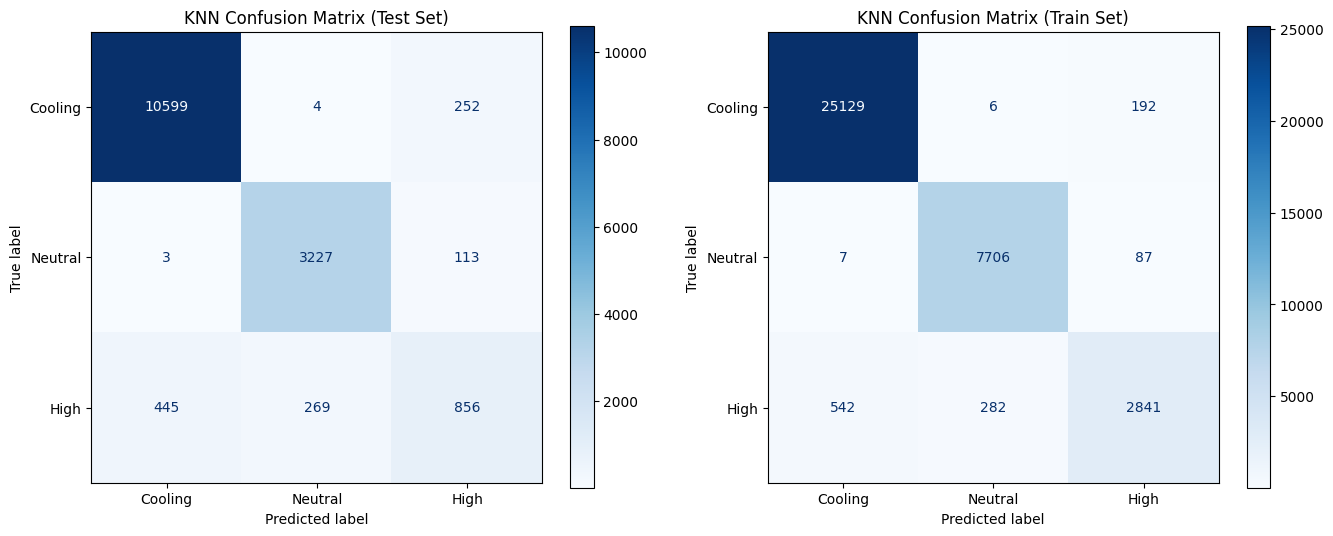

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Create confusion matrix for test set
cm_knn_test = confusion_matrix(y_test_knn, y_test_pred_knn)

# Display confusion matrix for test set
disp_knn_test = ConfusionMatrixDisplay(cm_knn_test, display_labels = ['Cooling','Neutral','High']) # Corrected display_labels to match actual classes
disp_knn_test.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('KNN Confusion Matrix (Test Set)')
ax1.grid(False)

# Create confusion matrix for train set
cm_knn_train = confusion_matrix(y_train_knn, y_train_pred_knn)

# Display confusion matrix for train set
disp_knn_train = ConfusionMatrixDisplay(cm_knn_train, display_labels = ['Cooling','Neutral','High']) # Corrected display_labels to match actual classes
disp_knn_train.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('KNN Confusion Matrix (Train Set)')
ax2.grid(False)

print("Confusion Matrix (Test Set):")
print(cm_knn_test)
print("\nConfusion Matrix (Train Set):")
print(cm_knn_train)

Similarly to the LR model, the KNN model struggled with neutral classification as can be seen by the confusion matrix above. However, it did do better slightly across metrics with classifying neutral, and with balancing of classes, and other optimization may improve.

KNN Model and Arch.:

KNN is a non-parametric, instance-based learning algorithm that classifies samples based on the majority class of their nearest neighbors in feature space. It would be decent for multiclass and hopefully would perform well with more balanced data, in its tuned conditions. It uses the following:

Input: Scaled numerical features

Distance metric: Euclidean (Minkowski with p = 2)

Number of neighbors (k): Controls bias–variance tradeoff

Weighting scheme: Distance-weighted voting

Output: Most frequent class among k neighbors

###5.3: Model 3: Decision Tree

###5.3a: Normalizing the Features

In [ ]:
# Not required for Decision Tree Model
scaler_dt = MinMaxScaler()

# Fit and transform the features
X_dec_tree_scaled = scaler_dt.fit_transform(X)

# Verify normalization (all values should be between 0 and 1)
print(f"Min value after scaling: {X_dec_tree_scaled.min()}")
print(f"Max value after scaling: {X_dec_tree_scaled.max()}")

Min value after scaling: 0.0
Max value after scaling: 1.0


A min max scaler was used again for decision tree, but scaling is not necessary for this model.

###5.3b: Splitting Data into Training and Test Sets

In [ ]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dec_tree_scaled, y, stratify = y,
    test_size=0.25, random_state=101)

print(f"Training set size: {X_train_dt.shape[0]}")
print(f"Test set size: {X_train_dt.shape[0]}")
print(f"Training set class distribution:\n{y_traindf.value_counts()}")

Training set size: 39420
Test set size: 39420
Training set class distribution:
operational_mode
Cooling             28942
Heating              8872
Neutral              4234
Name: count, dtype: int64


A test size of 0.25 was chosen for this model in order to prevent overfitting, which I felt may be mroe likely in a more complex model like decision tree.

###5.3c: Setting Up the Decision Tree Model

In [ ]:
# Defining Decision Tree Object
dt = DecisionTreeClassifier(
    max_depth=10,           # Limit tree depth
    min_samples_split=20,   # Minimum samples to split a node
    min_samples_leaf=10,    # Minimum samples in a leaf
    random_state=101
)

# Training the model
dt.fit(X_train_dt, y_train_dt)

print("Model trained successfully!")
print(f"Number of classes: {dt.n_classes_}")
print(f"Classes: {dt.classes_}")

# Making predictions on both training and test sets
y_test_pred_dt = dt.predict(X_test_dt)
y_train_pred_dt = dt.predict(X_train_dt)

print("Predictions made successfully!")
print("="*60)
print(f"\nFirst 10 test predictions: {y_test_pred_dt[:10]}")
print("="*60)
print(f"First 10 actual test values: {y_test_dt.values[:10]}")

Model trained successfully!
Number of classes: 3
Classes: ['Cooling' 'Heating' 'Neutral']
Predictions made successfully!

First 10 test predictions: ['Cooling' 'Cooling' 'Cooling' 'Cooling' 'Cooling' 'Cooling' 'Neutral'
 'Cooling' 'Cooling' 'Cooling']
First 10 actual test values: ['Cooling' 'Cooling' 'Cooling' 'Cooling' 'Cooling' 'Cooling' 'Cooling'
 'Cooling' 'Neutral' 'Cooling']


The current parameters such as depth were chosen from class notes in order to create a baseline model. Loss reports and convergence will help to determine which depth provides a balance between accuracy and not overfitting later in the notebook.

###5.3d: Visualizing the Decision Tree

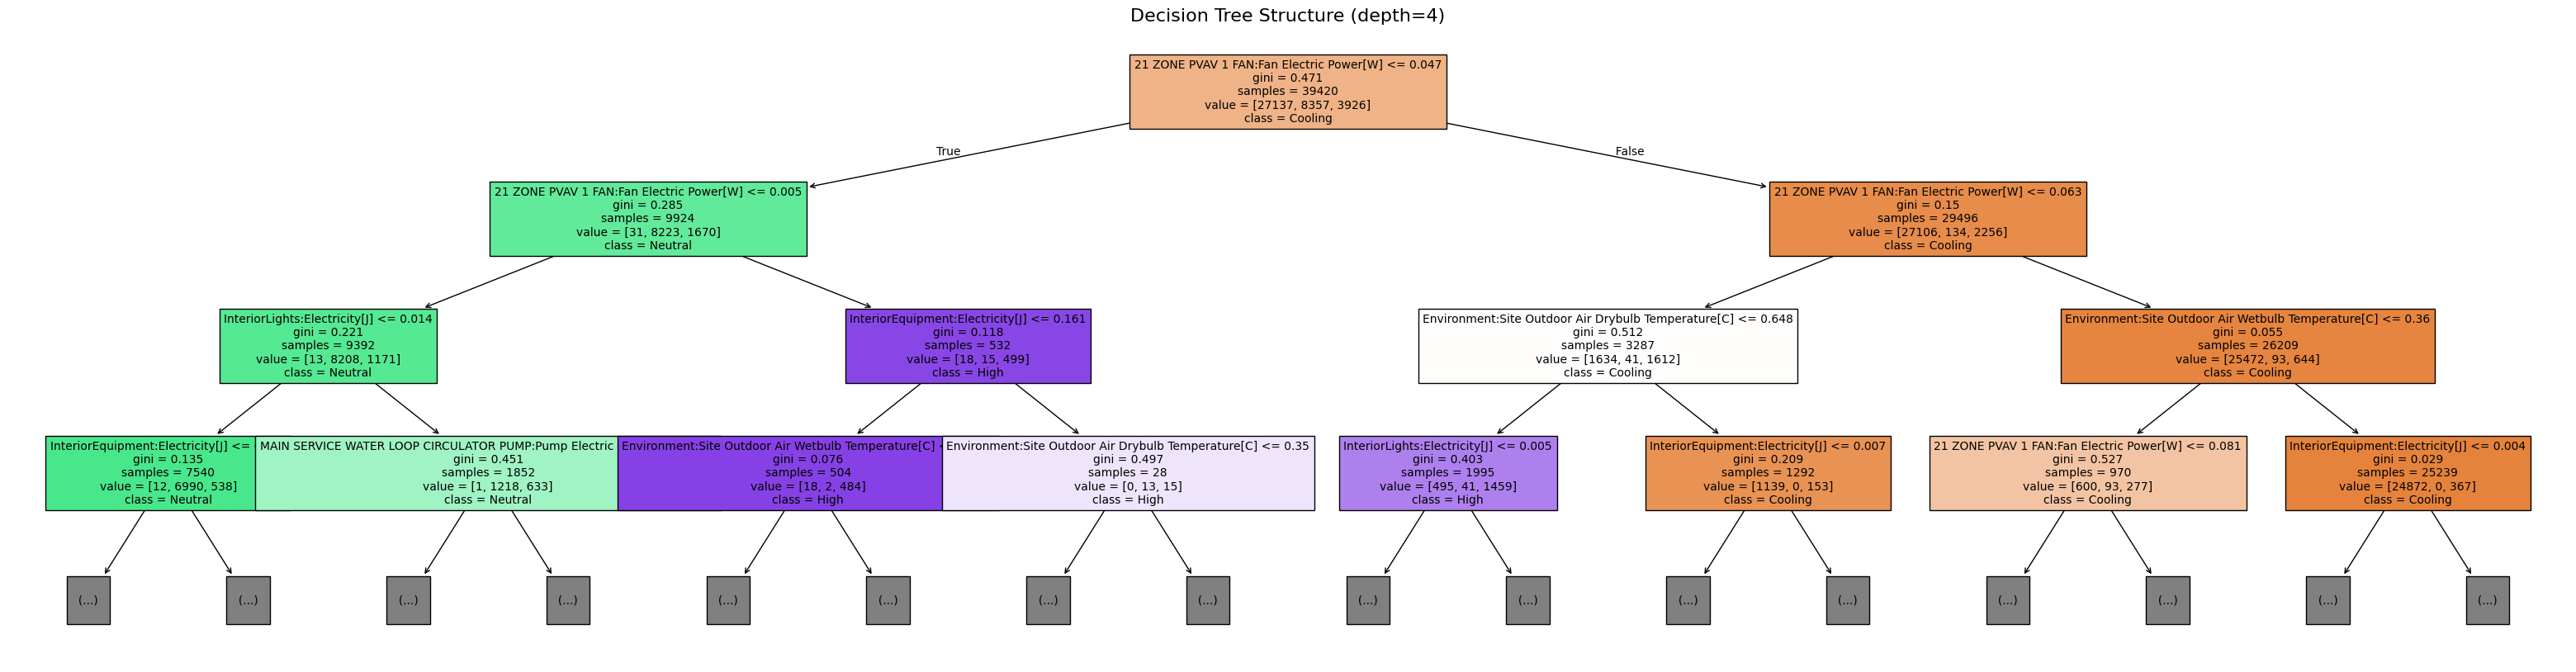


Decision Tree Rules (first 3 levels):
|--- 21 ZONE PVAV 1 FAN:Fan Electric Power[W] <= 0.05
|   |--- 21 ZONE PVAV 1 FAN:Fan Electric Power[W] <= 0.01
|   |   |--- InteriorLights:Electricity[J] <= 0.01
|   |   |   |--- InteriorEquipment:Electricity[J] <= 0.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- InteriorEquipment:Electricity[J] >  0.00
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- InteriorLights:Electricity[J] >  0.01
|   |   |   |--- MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W] <= 0.40
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W] >  0.40
|   |   |   |   |--- class: Heating
|   |--- 21 ZONE PVAV 1 FAN:Fan Electric Power[W] >  0.01
|   |   |--- InteriorEquipment:Electricity[J] <= 0.16
|   |   |   |--- Environment:Site Outdoor Air Wetbulb Temperature[C] <= 0.71
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- Environment:Site 

In [ ]:
# Figure Representation
plt.figure(figsize = (40,10))
tree.plot_tree(
    dt,
    max_depth = 3,
    feature_names = features,
    class_names = ['Cooling','Neutral','High'],
    filled = True,
    fontsize = 10
)

plt.title('Decision Tree Structure (depth=4)', fontsize=16)
plt.show()

# Text representation
text_representation = tree.export_text(dt, max_depth=3, feature_names=features)
print("\nDecision Tree Rules (first 3 levels):")
print(text_representation)

5.3e: Feature Importance

Feature Importances:
                                              feature  importance
7            21 ZONE PVAV 1 FAN:Fan Electric Power[W]    0.786390
0   Environment:Site Outdoor Air Drybulb Temperatu...    0.047804
1   Environment:Site Outdoor Air Wetbulb Temperatu...    0.033923
9   MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump E...    0.028214
4                       InteriorLights:Electricity[J]    0.027990
5                    InteriorEquipment:Electricity[J]    0.024919
12                                            weekday    0.021371
8     21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]    0.016079
11                                               hour    0.003612
13                                              month    0.003005
6                       ExteriorLights:Electricity[J]    0.002984
3   Environment:Site Outdoor Air Relative Humidity[%]    0.001624
2   Environment:Site Outdoor Air Dewpoint Temperat...    0.001094
10  MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump M...  

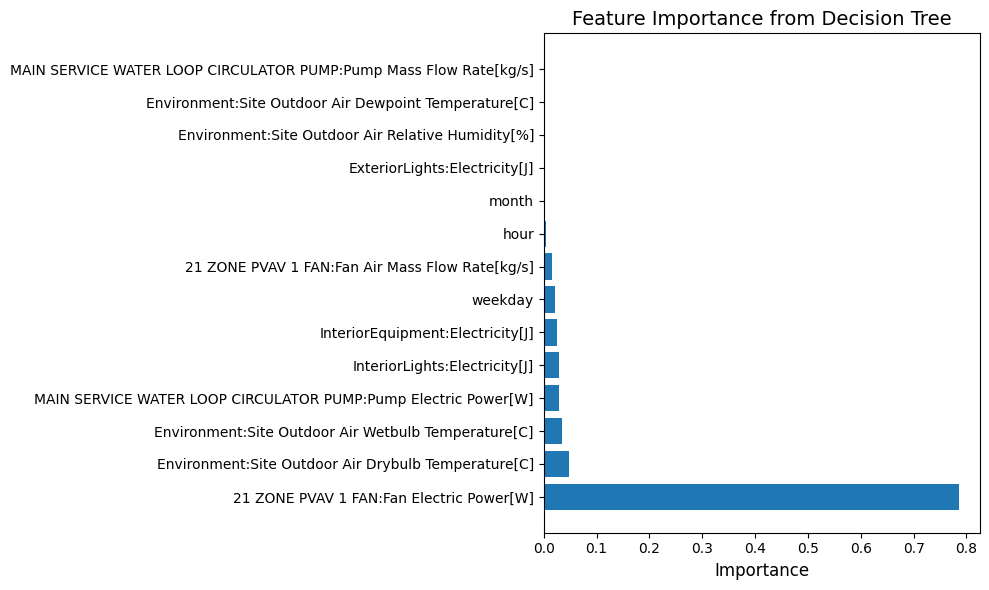

In [ ]:
# Deifning the importance
feature_importance = dt.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature' : features,
    'importance' : feature_importance
}).sort_values('importance', ascending = False)

print("Feature Importances:")
print("="*60)
print(feature_importance_df)
print("="*60)

# Importance Visualization
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df['feature'],
         feature_importance_df['importance'])
plt.xlabel('Importance', fontsize =12)
plt.title('Feature Importance from Decision Tree', fontsize=14)
plt.tight_layout()
plt.show()

Here, it is clear that there are some chosen features that of no significance to the trees decision making, and will just increase the dimensions of the model. This may or may not hurt the overall performance.

###5.3f: Evaluating Decision Tree Model

In [ ]:
# Calculate and print metrics for training set
acc_test_dt = accuracy_score(y_test_dt, y_test_pred_dt)
f1_test_dt = f1_score(y_test_dt, y_test_pred_dt, average='macro')
precision_dt_test = precision_score(y_test_dt, y_test_pred_dt, average='macro')
recall_dt_test = recall_score(y_test_dt, y_test_pred_dt, average='macro')

print("Decision Tree Test Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_dt:.3f} ({acc_test_dt*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_dt:.3f}")
print("="*60)
print(f"Precision:  {precision_dt_test:.3f}")
print("="*60)
print(f"Recall:  {recall_dt_test:.3f}")


# Calculate and print metrics for test set
acc_train_dt = accuracy_score(y_train_dt, y_train_pred_dt)
f1_train_dt = f1_score(y_train_dt, y_train_pred_dt, average='macro')
precision_dt_train = precision_score(y_train_dt, y_train_pred_dt, average='macro')
recall_dt_train = recall_score(y_train_dt, y_train_pred_dt, average='macro')

print("\nDecision Tree Training Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_train_dt:.3f}  ({acc_train_dt*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_train_dt:.3f}")
print("="*60)
print(f"Precision:  {precision_dt_train:.3f}")
print("="*60)
print(f"Recall:  {recall_dt_train:.3f}")

print(classification_report(y_test_dt, y_test_pred_dt))


Decision Tree Test Set Performance:
Accuracy:  0.973 (97.25%)
F1-Score:  0.939
Precision:  0.946
Recall:  0.933

Decision Tree Training Set Performance:
Accuracy:  0.979  (97.86%)
F1-Score:  0.952
Precision:  0.959
Recall:  0.945
              precision    recall  f1-score   support

     Cooling       0.99      0.99      0.99      9045
     Heating       0.95      0.98      0.97      2786
     Neutral       0.90      0.83      0.86      1309

    accuracy                           0.97     13140
   macro avg       0.95      0.93      0.94     13140
weighted avg       0.97      0.97      0.97     13140



The Decision Tree model perfomed really well and has already met the metrics goals for this project, with metrics all above 0.9 generally, while still perfoing 0.8 or better for neutral classification. There may be some overfitting due to high max depth though which will be checked later with loss.

###5.3g: Confusion Matrix for Decision Tree

Confusion Matrix (Test Set):
[[8959    1   85]
 [   5 2740   41]
 [  95  134 1080]]

Confusion Matrix (Train Set):
[[26972     1   164]
 [    9  8249    99]
 [  203   366  3357]]


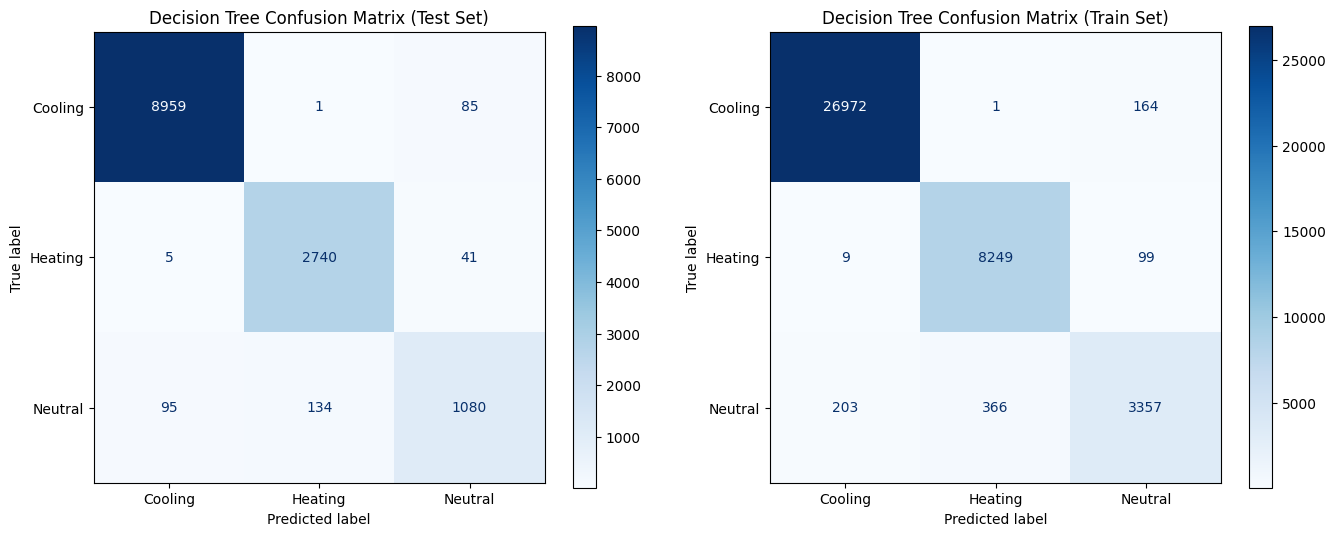

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Create confusion matrix for test set
cm_dt_test = confusion_matrix(y_test_dt, y_test_pred_dt)

# Display confusion matrix for test set
disp_dt_test = ConfusionMatrixDisplay(cm_dt_test, display_labels = dt.classes_) # Corrected display_labels to match actual classes
disp_dt_test.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Decision Tree Confusion Matrix (Test Set)')
ax1.grid(False)

# Create confusion matrix for train set
cm_dt_train = confusion_matrix(y_train_dt, y_train_pred_dt)

# Display confusion matrix for train set
disp_dt_train = ConfusionMatrixDisplay(cm_dt_train, display_labels = dt.classes_) # Corrected display_labels to match actual classes
disp_dt_train.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('Decision Tree Confusion Matrix (Train Set)')
ax2.grid(False)

print("Confusion Matrix (Test Set):")
print(cm_dt_test)
print("\nConfusion Matrix (Train Set):")
print(cm_dt_train)

This decision tree performed very well visually with the confusion matrix, as many neutral examples were classified correctly, showing that decision tree works well without data balancing, but could use with a class weight balance as a parameter later. This may drop precision but recall of neutral would be much better.

Decision Tree model architecture:
Decision Trees classify data by recursively splitting the feature space based on threshold values that maximize class separation. It was chosen since it can handle non-linear realationships well and you can easily access feature importance and reduce overfitting with leaves.

Input: Numerical features (no scaling required)

Splitting criterion: Gini impurity or entropy

Maximum depth: Limits tree complexity

Minimum samples per leaf: Prevents overfitting

Output: Class label at terminal leaf nodes

#6: Model Comparison and Next Steps

###6.1: Graphing Based Off Comparison Dataframe


COMPARISON OF BASELINE MODELS
                         Model  Accuracy  Precision   Recall  F1-Score
      Decision Tree (Baseline)  0.972527   0.945842 0.933013  0.938867
                KNN (Baseline)  0.931126   0.860837 0.828980  0.841470
Logistic Regression (Baseline)  0.928843   0.857683 0.793133  0.809512


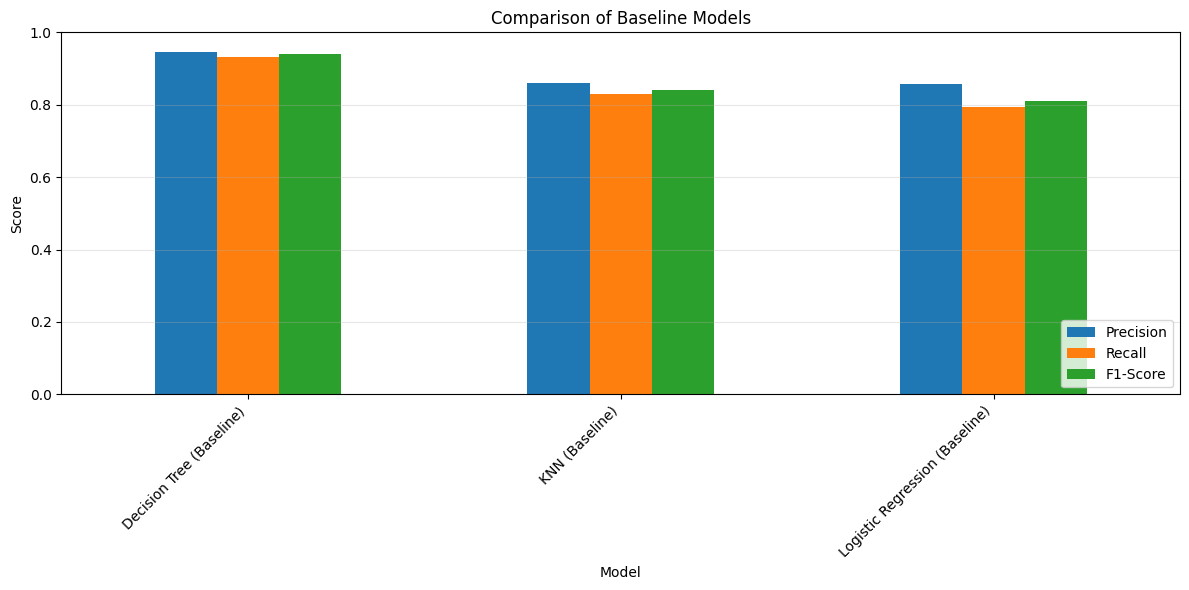

In [ ]:
print("\n" + "="*80)
print("COMPARISON OF BASELINE MODELS")
print("="*80)

# Comparison DataFrame for evaluation metrics
baseline_comparison = pd.DataFrame({
    'Model': ['Decision Tree (Baseline)', 'KNN (Baseline)', 'Logistic Regression (Baseline)'],
    'Accuracy': [
        accuracy_score(y_test_dt, y_test_pred_dt),
        accuracy_score(y_test_knn, y_test_pred_knn),
        accuracy_score(y_test_lr, y_test_pred_lr)
    ],
    'Precision': [
        precision_score(y_test_dt, y_test_pred_dt, average='macro'),
        precision_score(y_test_knn, y_test_pred_knn, average='macro'),
        precision_score(y_test_lr, y_test_pred_lr, average='macro')
    ],
    'Recall': [
        recall_score(y_test_dt, y_test_pred_dt, average='macro'),
        recall_score(y_test_knn, y_test_pred_knn, average='macro'),
        recall_score(y_test_lr, y_test_pred_lr, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test_dt, y_test_pred_dt, average='macro'),
        f1_score(y_test_knn, y_test_pred_knn, average='macro'),
        f1_score(y_test_lr, y_test_pred_lr, average='macro')
    ]
})

print(baseline_comparison.to_string(index=False))

# Visualize comparison
baseline_comparison.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6)
)
plt.title('Comparison of Baseline Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

###6.2: Correlation Matrix Comparisons

Confusion Matrices (Test Sets):
[[7113    1  126]
 [   5 2240   26]
 [ 296  294  411]]
[[10599     4   252]
 [    3  3227   113]
 [  445   269   856]]
[[8959    1   85]
 [   5 2740   41]
 [  95  134 1080]]


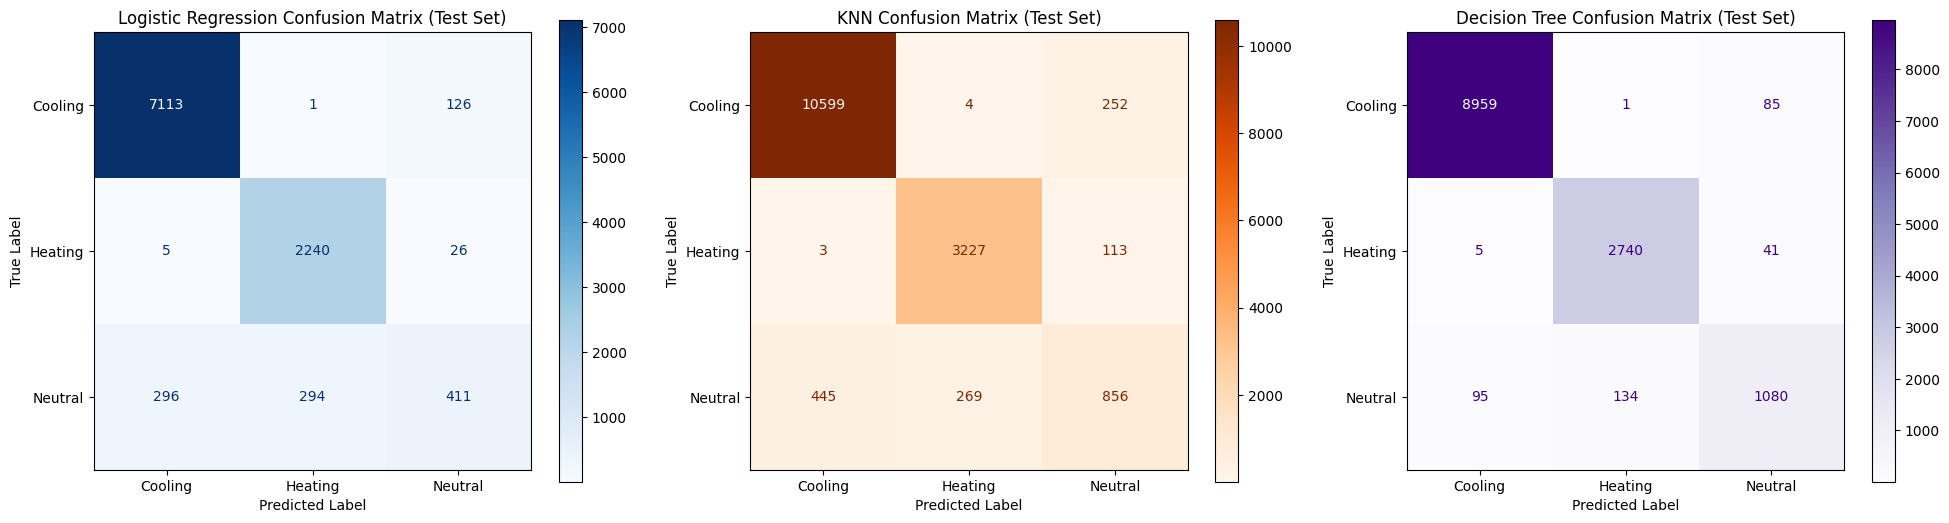

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

cm_lr_test = confusion_matrix(y_test_lr, y_test_pred_lr)
cm_knn_test = confusion_matrix(y_test_knn, y_test_pred_knn)
cm_dt_test = confusion_matrix(y_test_dt, y_test_pred_dt)

# Display confusion matrix for Logistic Regression test set
disp_lr_test = ConfusionMatrixDisplay(cm_lr_test, display_labels = dt.classes_)
disp_lr_test.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Logistic Regression Confusion Matrix (Test Set)')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.grid(False)

# Display confusion matrix for KNN test set
disp_knn_test = ConfusionMatrixDisplay(cm_knn_test, display_labels = dt.classes_)
disp_knn_test.plot(ax=ax2, cmap='Oranges', values_format='d')
ax2.set_title('KNN Confusion Matrix (Test Set)')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.grid(False)

# Display confusion matrix for decision tree test set
disp_dt_test = ConfusionMatrixDisplay(cm_dt_test, display_labels = dt.classes_)
disp_dt_test.plot(ax=ax3, cmap='Purples', values_format='d')
ax3.set_title('Decision Tree Confusion Matrix (Test Set)')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('True Label')
ax3.grid(False)

print("Confusion Matrices (Test Sets):")
print(cm_lr_test)
print(cm_knn_test)
print(cm_dt_test)




###6.3: Classification Report Comparison

In [ ]:
# Report on Decision Tree
print("Classification Report On Decision Tree:")
print(classification_report(y_test_dt, y_test_pred_dt))
print("="*60)

# Report on KNN
print("Classification Report On KNN:")
print(classification_report(y_test_knn, y_test_pred_knn))
print("="*60)

# Report on Logistic Regression
print("Classification Report On Logistic Regression:")
print(classification_report(y_test_lr, y_test_pred_lr))


Classification Report On Decision Tree:
              precision    recall  f1-score   support

     Cooling       0.99      0.99      0.99      9045
     Heating       0.95      0.98      0.97      2786
     Neutral       0.90      0.83      0.86      1309

    accuracy                           0.97     13140
   macro avg       0.95      0.93      0.94     13140
weighted avg       0.97      0.97      0.97     13140

Classification Report On KNN:
              precision    recall  f1-score   support

     Cooling       0.96      0.98      0.97     10855
     Heating       0.92      0.97      0.94      3343
     Neutral       0.70      0.55      0.61      1570

    accuracy                           0.93     15768
   macro avg       0.86      0.83      0.84     15768
weighted avg       0.93      0.93      0.93     15768

Classification Report On Logistic Regression:
              precision    recall  f1-score   support

     Cooling       0.96      0.98      0.97      7240
     Heating 

All of the figure representations and the reports demonstrate that with the imbalanced data, the Decision Tree performs the best in baseline. The KNN and LR models struggle with a common imbalance issue, with generally high accuracy, and high precision, F1-score, and recall for cooling and even heating, but the same measurements for the neutral class struggle to get above 0.6. Decision Tree, despite the unbalanced data managed to get above 0.8 for precision, recall, and F1-score for neutral. With more balanced data, through processing the imbalanced data, the models are all expected to do much better across measurements.

The comparison graph visually shows the disparities of the KNN model and LR model. Decision Tree is suitable for multiclass problems, along with KNN. However, Logistic Regression is more commonly used in binary classification, but was used for this multiclass situation. These results also shows that there is likely no data leakage causing unrealistically "good" models. Correlation matrices visually show that all the models including the decision tree struggle with false negatives and positives, commonly missing many neutral classifications. This is not immediately damaging as it can be in medicla diagnosis, or in products, however overtime, misclassifications will create an inefficient energy system through the years, and be wasteful, and hurtful for the environment.

The last thing of notice was in the decision tree model section, where the feature importance was shown to be high in the Fans which is quite plausible, as this is a measured system behavior.There are mutple features that have importance less than 0.01, which, when removed, may decrease dimensionality, and increase performance along with class balance.

#7: Data Preprocessing Part 2 (Balancing Data)

###7.1: Exploring Current Class Distribution


Class Distribution:
operational_mode
Cooling    36182
Heating    11143
Neutral     5235
Name: count, dtype: int64

Class Distribution (Percentage):
operational_mode
Cooling    68.839422
Heating    21.200533
Neutral     9.960046
Name: proportion, dtype: float64


/tmp/ipython-input-1205626790.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Heating', 'Neutral', 'Cooling'])


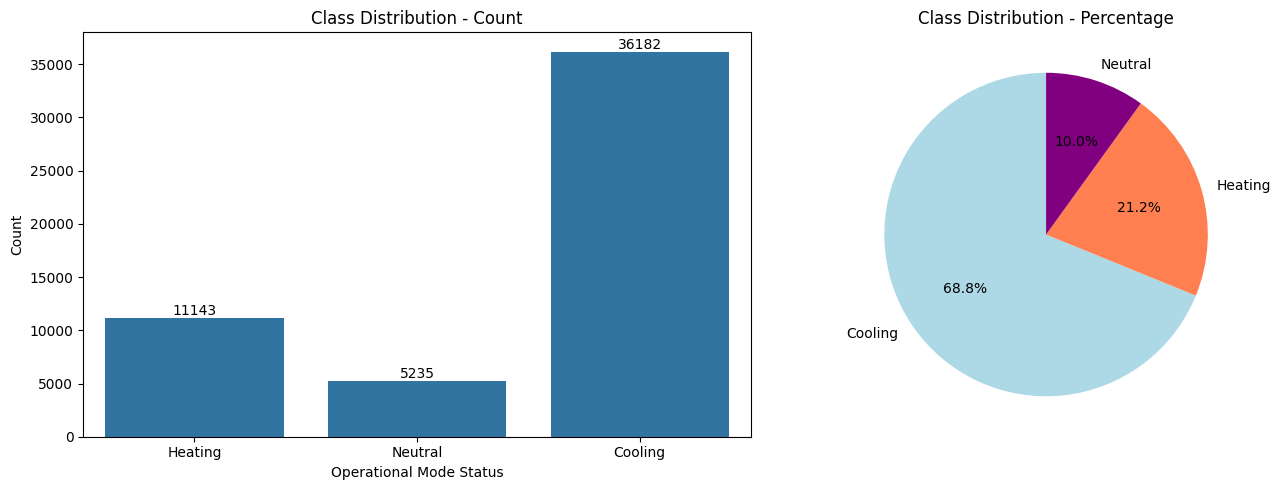

In [ ]:
# Checking the Class Distribution
print("\nClass Distribution:")
print(df['operational_mode'].value_counts())

print("\nClass Distribution (Percentage):")
print(df['operational_mode'].value_counts(normalize=True)*100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class Distrbution Chart
sns.countplot(data=df, x = 'operational_mode', ax = axes[0])
axes[0].set_title('Class Distribution - Count')
axes[0].set_xlabel('Operational Mode Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Heating', 'Neutral', 'Cooling'])

# Adding labels to the count plots on bars
for container in axes[0].containers:
  axes[0].bar_label(container)

# Pie Chart
efficiency_counts = df['operational_mode'].value_counts()
axes[1].pie(efficiency_counts, labels = ['Cooling','Heating', 'Neutral'],\
            autopct='%1.1f%%', startangle = 90, colors=['lightblue', 'coral', 'purple'] )
axes[1].set_title('Class Distribution - Percentage')

plt.tight_layout()
plt.show()


As seen before from the value counts of the operational mode dataframe the data is very unbalanced. However, there is definitely a chance to fix it using either undersampling, oversampling or smote which will be shown next. The best balancing technique will then be used to retain tuned models with the hope of neutral classification getitng better throughout models.

### 7.2: Implementing Undersampling

In [ ]:
print("\n" + "="*80)
print("RANDOM UNDERSAMPLING")
print("="*80)

# Defining a general split for all models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Defining a sampling stategy that lowers dominance of cooling
sampling_strategy_rus = {
    'Cooling': 10000,
    'Heating': 8000,
    'Neutral': 4000
}

# Minmaxscaler on the current features
generalscaler = MinMaxScaler()
X_train_scaled_gen = generalscaler.fit_transform(X_train)
X_test_scaled_gen = generalscaler.transform(X_test)

rus = RandomUnderSampler(sampling_strategy = sampling_strategy_rus)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled_gen, y_train)

print(f"\nOriginal training set size: {len(X_train_scaled_gen)}")
print(f"After undersampling: {len(X_train_rus)}")
print(f"\nClass distribution after undersampling:")
print(pd.Series(y_train_rus).value_counts())



RANDOM UNDERSAMPLING

Original training set size: 42048
After undersampling: 22000

Class distribution after undersampling:
operational_mode
Cooling    10000
Heating     8000
Neutral     4000
Name: count, dtype: int64


###7.3: Training and Testing Models With Undersampled Data

In [ ]:
# Train KNN with undersampled data with k = 5
knn_rus = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    metric='minkowski')
knn_rus.fit(X_train_rus, y_train_rus)
y_pred_rus_knn = knn_rus.predict(X_test_scaled_gen)

# Train LR with undersampled data
lr_rus = LogisticRegression(
    C=0.1,
    solver='lbfgs',              # required for multinomial
    max_iter=1000,
    class_weight='balanced',           # baseline
    random_state=42)

lr_rus.fit(X_train_rus, y_train_rus)
y_pred_rus_lr = lr_rus.predict(X_test_scaled_gen)

# Calculate and print metrics for KNN test set
print("\n" + "="*80)
print("RANDOM UNDERSAMPLING FOR KNN")
print("="*80)
acc_test_knn_rus = accuracy_score(y_test, y_pred_rus_knn)
f1_test_knn_rus = f1_score(y_test, y_pred_rus_knn, average='macro')
precision_knn_rus = precision_score(y_test, y_pred_rus_knn, average='macro')
recall_knn_rus = recall_score(y_test, y_pred_rus_knn, average='macro')

print("\n KNN(undersampling) Test Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_knn_rus:.3f}  ({acc_test_knn_rus*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_knn_rus:.3f}")
print("="*60)
print(f"Precision:  {precision_knn_rus:.3f}")
print("="*60)
print(f"Recall:  {recall_knn_rus:.3f}")

print(classification_report(y_test, y_pred_rus_knn))

lr_rus.fit(X_train_rus, y_train_rus)
y_pred_rus_lr = lr_rus.predict(X_test_scaled_gen)

# Calculate and print metrics for LR test set
print("\n" + "="*80)
print("RANDOM UNDERSAMPLING FOR LR")
print("="*80)
acc_test_lr_rus = accuracy_score(y_test, y_pred_rus_lr)
f1_test_lr_rus = f1_score(y_test, y_pred_rus_lr, average='macro')
precision_lr_rus = precision_score(y_test, y_pred_rus_lr, average='macro')
recall_lr_rus = recall_score(y_test, y_pred_rus_lr, average='macro')

print("\nLR Test Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_lr_rus:.3f}  ({acc_test_lr_rus*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_lr_rus:.3f}")
print("="*60)
print(f"Precision:  {precision_lr_rus:.3f}")
print("="*60)
print(f"Recall:  {recall_lr_rus:.3f}")

print(classification_report(y_test, y_pred_rus_lr))




RANDOM UNDERSAMPLING FOR KNN

 KNN(undersampling) Test Set Performance:
Accuracy:  0.916  (91.55%)
F1-Score:  0.845
Precision:  0.824
Recall:  0.873
              precision    recall  f1-score   support

     Cooling       0.98      0.92      0.95      7236
     Heating       0.93      0.99      0.96      2229
     Neutral       0.56      0.71      0.63      1047

    accuracy                           0.92     10512
   macro avg       0.82      0.87      0.85     10512
weighted avg       0.93      0.92      0.92     10512


RANDOM UNDERSAMPLING FOR LR

LR Test Set Performance:
Accuracy:  0.882  (88.18%)
F1-Score:  0.797
Precision:  0.770
Recall:  0.844
              precision    recall  f1-score   support

     Cooling       0.99      0.88      0.93      7236
     Heating       0.88      0.98      0.93      2229
     Neutral       0.44      0.67      0.53      1047

    accuracy                           0.88     10512
   macro avg       0.77      0.84      0.80     10512
weighted av

Using undersampling did little to improve the neutral classification of the KNN model but worked somwhat for the logistic regression multiclass model with all measurements being above 0.55. The size of the dominant cooling class was set to 12000 for these metrics which also cause a major amount of lost data, meanign this sampling technique was ineffective, in this case. This definitely hurt KNN the most since it randomly removes valid neighbors which KNN relies on.

### 7.4: Implementing Oversampling

In [ ]:
print("\n" + "="*80)
print("RANDOM OVERSAMPLING")
print("="*80)

# Defining a sampling stategy that raises dominance of neutral and heating
sampling_strategy_ros = {
    'Cooling': 36000,
    'Heating': 25000,
    'Neutral': 20000
}

# Minmaxscaler on the current features
generalscaler = MinMaxScaler()
X_train_scaled_gen = generalscaler.fit_transform(X_train)
X_test_scaled_gen = generalscaler.transform(X_test)

ros = RandomOverSampler(sampling_strategy = sampling_strategy_ros)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled_gen, y_train)

print(f"\nOriginal training set size: {len(X_train_scaled_gen)}")
print(f"After undersampling: {len(X_train_ros)}")
print(f"\nClass distribution after undersampling:")
print(pd.Series(y_train_ros).value_counts())



RANDOM OVERSAMPLING

Original training set size: 42048
After undersampling: 81000

Class distribution after undersampling:
operational_mode
Cooling    36000
Heating    25000
Neutral    20000
Name: count, dtype: int64


###7.5: Training and Testing Models With Oversampled Data

In [ ]:
# Train KNN with oversampled data with k = 15
knn_ros = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    metric='minkowski')
knn_ros.fit(X_train_ros, y_train_ros)
y_pred_ros_knn = knn_ros.predict(X_test_scaled_gen)

# Train LR with oversampled data
lr_ros = LogisticRegression(
    C=0.1,
    solver='lbfgs',              # required for multinomial
    max_iter=1000,
    class_weight='balanced',           # baseline
    random_state=42)

lr_ros.fit(X_train_ros, y_train_ros)
y_pred_ros_lr = lr_ros.predict(X_test_scaled_gen)

# Calculate and print metrics for KNN test set
print("\n" + "="*80)
print("RANDOM OVERSAMPLING FOR KNN")
print("="*80)
acc_test_knn_ros = accuracy_score(y_test, y_pred_ros_knn)
f1_test_knn_ros = f1_score(y_test, y_pred_ros_knn, average='macro')
precision_knn_ros = precision_score(y_test, y_pred_ros_knn, average='macro')
recall_knn_ros = recall_score(y_test, y_pred_ros_knn, average='macro')

print("\nDecision Tree Training Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_knn_ros:.3f}  ({acc_test_knn_ros*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_knn_ros:.3f}")
print("="*60)
print(f"Precision:  {precision_knn_ros:.3f}")
print("="*60)
print(f"Recall:  {recall_knn_ros:.3f}")

print(classification_report(y_test, y_pred_ros_knn))

lr_rus.fit(X_train_rus, y_train_rus)
y_pred_rus_lr = lr_rus.predict(X_test_scaled_gen)

# Calculate and print metrics for LR test set
print("\n" + "="*80)
print("RANDOM OVERSAMPLING FOR LR")
print("="*80)
acc_test_lr_ros = accuracy_score(y_test, y_pred_ros_lr)
f1_test_lr_ros = f1_score(y_test, y_pred_ros_lr, average='macro')
precision_lr_ros = precision_score(y_test, y_pred_ros_lr, average='macro')
recall_lr_ros = recall_score(y_test, y_pred_ros_lr, average='macro')

print("\nDecision Tree Training Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_lr_ros:.3f}  ({acc_test_lr_ros*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_lr_ros:.3f}")
print("="*60)
print(f"Precision:  {precision_lr_ros:.3f}")
print("="*60)
print(f"Recall:  {recall_lr_ros:.3f}")

print(classification_report(y_test, y_pred_ros_lr))




RANDOM OVERSAMPLING FOR KNN

Decision Tree Training Set Performance:
Accuracy:  0.911  (91.10%)
F1-Score:  0.845
Precision:  0.824
Recall:  0.881
              precision    recall  f1-score   support

     Cooling       0.98      0.92      0.95      7236
     Heating       0.95      0.95      0.95      2229
     Neutral       0.54      0.77      0.63      1047

    accuracy                           0.91     10512
   macro avg       0.82      0.88      0.85     10512
weighted avg       0.93      0.91      0.92     10512


RANDOM OVERSAMPLING FOR LR

Decision Tree Training Set Performance:
Accuracy:  0.888  (88.77%)
F1-Score:  0.802
Precision:  0.775
Recall:  0.844
              precision    recall  f1-score   support

     Cooling       0.99      0.89      0.94      7236
     Heating       0.88      0.99      0.93      2229
     Neutral       0.46      0.66      0.54      1047

    accuracy                           0.89     10512
   macro avg       0.77      0.84      0.80     10512


Random oversampling definitely helped with the neutral classification in both LR and KNN models with KNN having higher recall and LR generally getting higher across measuremnts. However, this is with significant increase in Heating and Neutral classes, precision is dropping, and the metrics are still not above a more desirable 0.8.

###7.6 SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
from imblearn.over_sampling import SMOTE

print("\n" + "="*80)
print("SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)")
print("="*80)

# Defining a sampling stategy that raises dominance of neutral and heating
sampling_strategy_smote = {
    'Cooling': 36000,
    'Heating': 25000,
    'Neutral': 20000
}

# SMOTE with sampling_strategy
smote = SMOTE(sampling_strategy=sampling_strategy_smote)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_gen, y_train)

print(f"\nOriginal training set size: {len(X_train_scaled_gen)}")
print(f"After SMOTE: {len(X_train_smote)}")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)

Original training set size: 42048
After SMOTE: 81000

Class distribution after SMOTE:
operational_mode
Cooling    36000
Heating    25000
Neutral    20000
Name: count, dtype: int64


###7.7: Training and Testing Models With SMOTE Data

In [ ]:
# Train KNN with SMOTE data
knn_smote = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    metric='minkowski')
knn_smote.fit(X_train_smote,y_train_smote)
y_pred_smote_knn = knn_smote.predict(X_test_scaled_gen)

# Train LR with SMOTE data
lr_smote = LogisticRegression(
    C=0.1,
    solver='lbfgs',              # required for multinomial
    max_iter=1000,
    class_weight='balanced',           # baseline
    random_state=42)

lr_smote.fit(X_train_smote, y_train_smote)
y_pred_smote_lr = lr_smote.predict(X_test_scaled_gen)

# Calculate and print metrics for KNN test set
print("\n" + "="*80)
print("RANDOM OVERSAMPLING FOR KNN")
print("="*80)
acc_test_knn_smote = accuracy_score(y_test, y_pred_smote_knn)
f1_test_knn_smote = f1_score(y_test, y_pred_smote_knn, average='macro')
precision_knn_smote = precision_score(y_test, y_pred_smote_knn, average='macro')
recall_knn_smote = recall_score(y_test, y_pred_smote_knn, average='macro')

print("\nKNN SMOTE Test Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_knn_smote:.3f}  ({acc_test_knn_smote*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_knn_smote:.3f}")
print("="*60)
print(f"Precision:  {precision_knn_smote:.3f}")
print("="*60)
print(f"Recall:  {recall_knn_smote:.3f}")

print(classification_report(y_test, y_pred_smote_knn))

# Calculate and print metrics for LR test set
print("\n" + "="*80)
print("RANDOM OVERSAMPLING FOR LR")
print("="*80)
acc_test_lr_smote = accuracy_score(y_test, y_pred_smote_lr)
f1_test_lr_smote = f1_score(y_test, y_pred_smote_lr, average='macro')
precision_lr_smote = precision_score(y_test, y_pred_smote_lr, average='macro')
recall_lr_smote = recall_score(y_test, y_pred_smote_lr, average='macro')

print("\nLR SMOTE Test Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_lr_smote:.3f}  ({acc_test_lr_smote*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_lr_smote:.3f}")
print("="*60)
print(f"Precision:  {precision_lr_smote:.3f}")
print("="*60)
print(f"Recall:  {recall_lr_smote:.3f}")

print(classification_report(y_test, y_pred_smote_lr))



RANDOM OVERSAMPLING FOR KNN

KNN SMOTE Test Set Performance:
Accuracy:  0.912  (91.15%)
F1-Score:  0.845
Precision:  0.824
Recall:  0.880
              precision    recall  f1-score   support

     Cooling       0.98      0.92      0.95      7236
     Heating       0.95      0.96      0.95      2229
     Neutral       0.54      0.77      0.63      1047

    accuracy                           0.91     10512
   macro avg       0.82      0.88      0.85     10512
weighted avg       0.93      0.91      0.92     10512


RANDOM OVERSAMPLING FOR LR

LR SMOTE Test Set Performance:
Accuracy:  0.888  (88.82%)
F1-Score:  0.802
Precision:  0.775
Recall:  0.845
              precision    recall  f1-score   support

     Cooling       0.99      0.89      0.94      7236
     Heating       0.88      0.99      0.93      2229
     Neutral       0.46      0.66      0.54      1047

    accuracy                           0.89     10512
   macro avg       0.78      0.84      0.80     10512
weighted avg     

###7.8: Compare Resampling Techniques for KNN


COMPARISON OF RESAMPLING TECHNIQUES
       Method  Accuracy  Precision   Recall  F1-Score
     Baseline  0.931126   0.860837 0.828980  0.841470
Undersampling  0.915525   0.824434 0.873171  0.845498
 Oversampling  0.910959   0.823755 0.881078  0.845254
        SMOTE  0.911530   0.823552 0.880200  0.845080


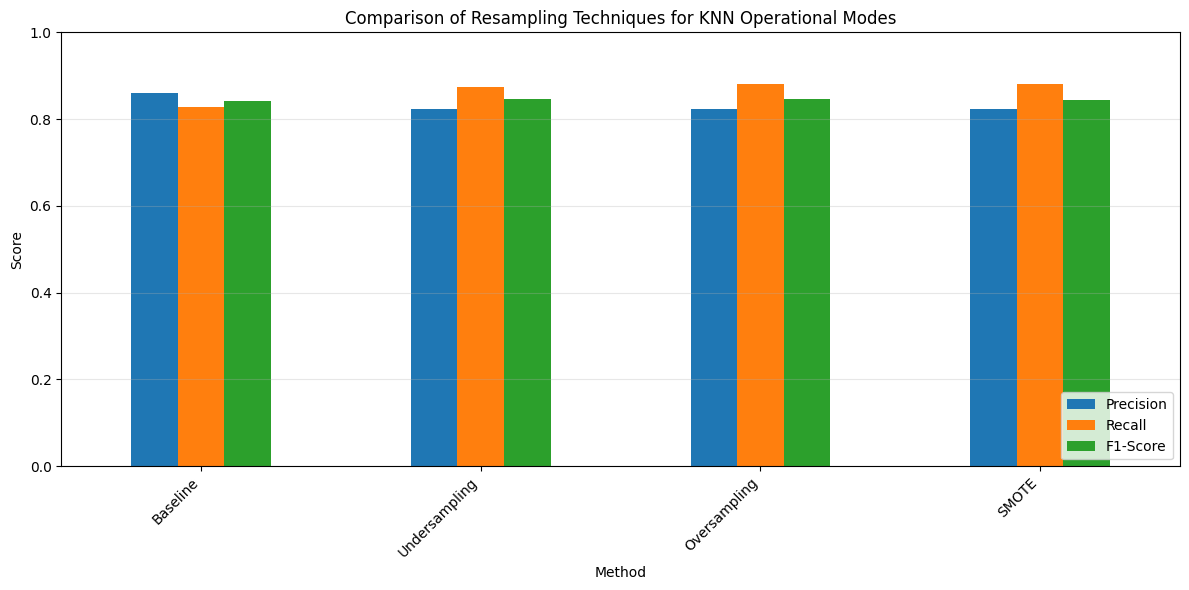

In [ ]:
# DataFrame to easily plot the comparison
comparison_df = pd.DataFrame({
    'Method': ['Baseline', 'Undersampling', 'Oversampling', 'SMOTE'],
    'Accuracy': [
        accuracy_score(y_test_knn, y_test_pred_knn),
        accuracy_score(y_test, y_pred_rus_knn),
        accuracy_score(y_test, y_pred_ros_knn),
        accuracy_score(y_test, y_pred_smote_knn)
    ],
    'Precision': [
        precision_score(y_test_knn, y_test_pred_knn,average='macro'),
        precision_score(y_test, y_pred_rus_knn, average='macro'),
        precision_score(y_test, y_pred_ros_knn, average='macro'),
        precision_score(y_test, y_pred_smote_knn, average='macro')
    ],
    'Recall': [
        recall_score(y_test_knn, y_test_pred_knn, average='macro'),
        recall_score(y_test, y_pred_rus_knn, average='macro'),
        recall_score(y_test, y_pred_ros_knn, average='macro'),
        recall_score(y_test, y_pred_smote_knn, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test_knn, y_test_pred_knn, average='macro'),
        f1_score(y_test, y_pred_rus_knn, average='macro'),
        f1_score(y_test, y_pred_ros_knn, average='macro'),
        f1_score(y_test, y_pred_smote_knn, average='macro')
    ]
})

print("\n" + "="*80)
print("COMPARISON OF RESAMPLING TECHNIQUES")
print("="*80)
print(comparison_df.to_string(index=False))

# comparing
comparison_df.set_index('Method')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6)
)
plt.title('Comparison of Resampling Techniques for KNN Operational Modes')
plt.ylabel('Score')
plt.xlabel('Method')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Here, the baseling model had the highest precision, but also had the lowest recall. The sampling techniques rose the recall but at the expense of some precision, while the F1 scores remained similar. While the macro weighted metrics shown that the KNN model works decently with metrics above 0.8 the neutral class classification is still lacking in classificaiton reports. Still the sampling techniques did not help the KNN model reach 0.7 or 0.8 across all measurement categories.

###7.9: Compare Resampling Techniques for LR


COMPARISON OF RESAMPLING TECHNIQUES
       Method  Accuracy  Precision   Recall  F1-Score
     Baseline  0.928843   0.860837 0.828980  0.841470
Undersampling  0.881754   0.769875 0.843943  0.796948
 Oversampling  0.887747   0.774991 0.844198  0.801671
        SMOTE  0.888223   0.775320 0.844532  0.802074


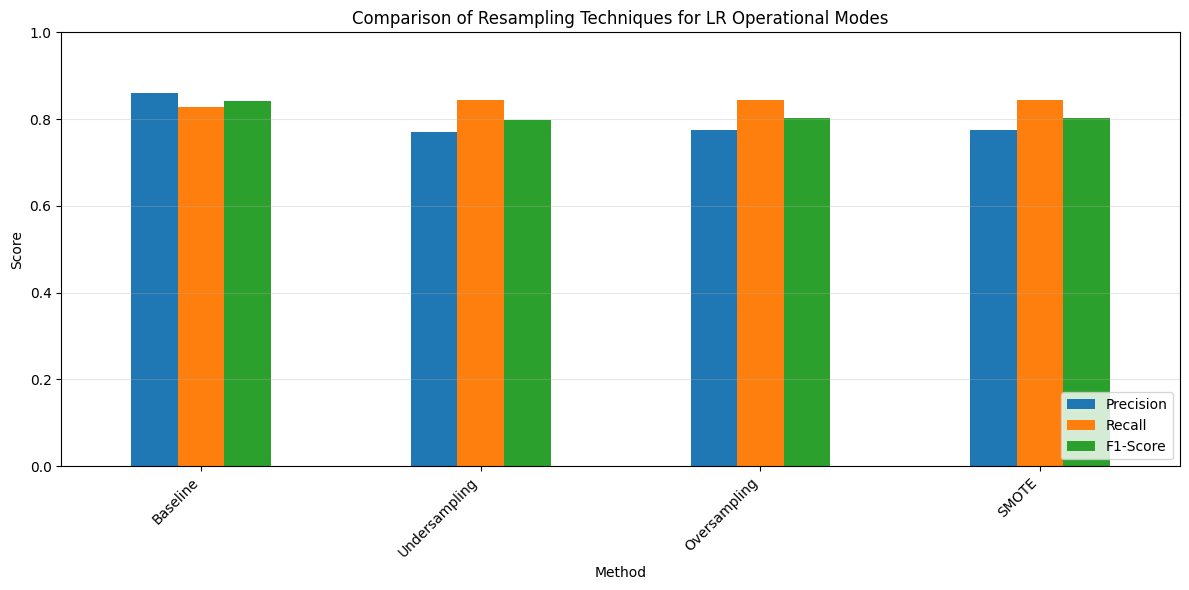

In [ ]:
# DataFrame to easily plot the comparison
comparison_df = pd.DataFrame({
    'Method': ['Baseline', 'Undersampling', 'Oversampling', 'SMOTE'],
    'Accuracy': [
        accuracy_score(y_test_lr, y_test_pred_lr),
        accuracy_score(y_test, y_pred_rus_lr),
        accuracy_score(y_test, y_pred_ros_lr),
        accuracy_score(y_test, y_pred_smote_lr)
    ],
    'Precision': [
        precision_score(y_test_knn, y_test_pred_knn,average='macro'),
        precision_score(y_test, y_pred_rus_lr, average='macro'),
        precision_score(y_test, y_pred_ros_lr, average='macro'),
        precision_score(y_test, y_pred_smote_lr, average='macro')
    ],
    'Recall': [
        recall_score(y_test_knn, y_test_pred_knn, average='macro'),
        recall_score(y_test, y_pred_rus_lr, average='macro'),
        recall_score(y_test, y_pred_ros_lr, average='macro'),
        recall_score(y_test, y_pred_smote_lr, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test_knn, y_test_pred_knn, average='macro'),
        f1_score(y_test, y_pred_rus_lr, average='macro'),
        f1_score(y_test, y_pred_ros_lr, average='macro'),
        f1_score(y_test, y_pred_smote_lr, average='macro')
    ]
})

print("\n" + "="*80)
print("COMPARISON OF RESAMPLING TECHNIQUES")
print("="*80)
print(comparison_df.to_string(index=False))

# comparing
comparison_df.set_index('Method')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6)
)
plt.title('Comparison of Resampling Techniques for LR Operational Modes')
plt.ylabel('Score')
plt.xlabel('Method')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Similar to the KNN sampling results the LR has decent macro metrics all above 0.8 with declining precision and increasing recall. However, its neutral class classification metrics are worse than the KNN barely surpassing 0.6 across metrics. This means either another technique will have to be used, and feature selection will have to be optimized in order to hopefully raise the metrics. For KNN Hyperparameter Tuning will be attempted next as well RFE and corss validation techniques for LR. The features will also be inspected given in attempt to imprvoe the models to at least above 0.6 or 0.7 across metrics. For these inspections SMOTE balancing will be used. A class weight balance was also used to ensure more consideration of neutral.

### 8: Model Optimization

###8.1: Feature Selection

In [ ]:
from sklearn.feature_selection import RFE

print("\n" + "="*80)
print("RECURSIVE FEATURE ELIMINATION (RFE)")
print("="*80)

# Logistic Regression as the estimator
lr_rfe = LogisticRegression(
    C=0.1,
    solver='lbfgs',              # required for multinomial
    max_iter=1000,
    class_weight='balanced',           # baseline
    random_state=42)

# Create RFE object to select 10 features
rfe = RFE(
    estimator=lr_rfe,
    n_features_to_select=5,
    step=1
)

# Fit RFE
print("\nFitting RFE...")
rfe.fit(X_train_smote, y_train_smote)

# Get selected features
selected_features_rfe = X.columns[rfe.support_]
print(f"\nSelected features ({len(selected_features_rfe)}):")
for i, feature in enumerate(selected_features_rfe, 1):
    print(f"  {i}. {feature}")

# feature rankings
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("\nAll features with rankings:")
print(feature_ranking.to_string(index=False))

# transforming data
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test_scaled_gen)

# training model with selected features
lr_with_rfe = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

lr_with_rfe.fit(X_train_rfe, y_train_smote)
y_pred_rfe = lr_with_rfe.predict(X_test_rfe)

print("\n--- Logistic Regression with RFE Selected Features ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rfe):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rfe, average = 'macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rfe, average = 'macro'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rfe, average = 'macro'):.4f}")


print(classification_report(y_test, y_pred_rfe))


RECURSIVE FEATURE ELIMINATION (RFE)

Fitting RFE...

Selected features (5):
  1. Environment:Site Outdoor Air Wetbulb Temperature[C]
  2. 21 ZONE PVAV 1 FAN:Fan Electric Power[W]
  3. 21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]
  4. MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W]
  5. MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Mass Flow Rate[kg/s]

All features with rankings:
                                                          Feature  Selected  Ranking
              Environment:Site Outdoor Air Wetbulb Temperature[C]      True        1
                         21 ZONE PVAV 1 FAN:Fan Electric Power[W]      True        1
   MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W]      True        1
                  21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]      True        1
MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Mass Flow Rate[kg/s]      True        1
                                 InteriorEquipment:Electricity[J]     False        2
    

The RFE was used on the LR model in order to reduce the amount of features with the hope of increasing performance. After using these features for LR and KNN along with an exhaustive gridsearch KNN and LR will improve with the class weight balance parameter as well as more K's or epochs.

###8.2: RFECV (RFE with Cross-Validation)


RFECV (RFE WITH CROSS-VALIDATION)

Fitting RFECV (this may take a minute)...

Optimal number of features: 14

Selected features:
  1. Environment:Site Outdoor Air Drybulb Temperature[C]
  2. Environment:Site Outdoor Air Wetbulb Temperature[C]
  3. Environment:Site Outdoor Air Dewpoint Temperature[C]
  4. Environment:Site Outdoor Air Relative Humidity[%]
  5. InteriorLights:Electricity[J]
  6. InteriorEquipment:Electricity[J]
  7. ExteriorLights:Electricity[J]
  8. 21 ZONE PVAV 1 FAN:Fan Electric Power[W]
  9. 21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]
  10. MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W]
  11. MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Mass Flow Rate[kg/s]
  12. hour
  13. weekday
  14. month


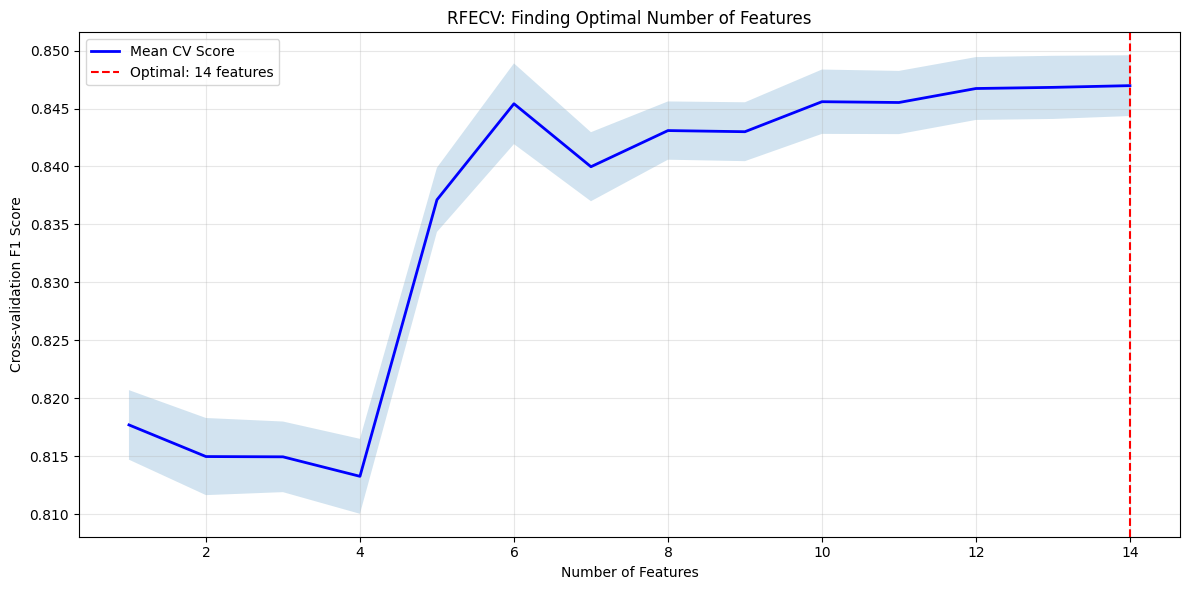


--- Logistic Regression with RFECV Selected Features ---
Accuracy:  0.9145
Precision: 0.8094
Recall:    0.8437
F1-Score:  0.8249


In [ ]:
from sklearn.feature_selection import RFECV

print("\n" + "="*80)
print("RFECV (RFE WITH CROSS-VALIDATION)")
print("="*80)

# creating RFECV object with stratified KFold
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    step=1,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# TODO: fitting RFECV
print("\nFitting RFECV (this may take a minute)...")
rfecv.fit(X_train_smote, y_train_smote)

print(f"\nOptimal number of features: {rfecv.n_features_}")
print(f"\nSelected features:")
selected_features_rfecv = X.columns[rfecv.support_]
for i, feature in enumerate(selected_features_rfecv, 1):
    print(f"  {i}. {feature}")

# plotting number of features vs. CV score
plt.figure(figsize=(12, 6))
n_features_range = range(1, len(rfecv.cv_results_['mean_test_score']) + 1)
plt.plot(n_features_range, rfecv.cv_results_['mean_test_score'],
         'b-', linewidth=2, label='Mean CV Score')
plt.fill_between(n_features_range,
                 rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                 rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'],
                 alpha=0.2)
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--',
           label=f'Optimal: {rfecv.n_features_} features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validation F1 Score')
plt.title('RFECV: Finding Optimal Number of Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# TODO: Transform data and evaluate
X_train_rfecv = rfecv.transform(X_train_smote)
X_test_rfecv = rfecv.transform(X_test_scaled_gen)

# TODO: Train and evaluate model
lr_with_rfecv = LogisticRegression(max_iter=1000, random_state=42)
lr_with_rfecv.fit(X_train_rfecv, y_train_smote)
y_pred_rfecv=lr_with_rfecv.predict(X_test_rfecv)

print("\n--- Logistic Regression with RFECV Selected Features ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rfecv):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rfecv, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rfecv, average='macro'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rfecv, average='macro'):.4f}")

While the RFECV method the feature amount selected was the same as what was intially chosen, however, it performed close to the RFE method which chose only 10 features. Therefore, the RFE may be preferred

###8.3: Compare Feature Selection Methods


FEATURE SELECTION COMPARISON
           Method  Num Features  Accuracy  Precision   Recall  F1-Score
     All Features            14  0.888223   0.775320 0.844532  0.802074
RFE (10 features)            10  0.912481   0.805268 0.840147  0.821061
            RFECV            14  0.914479   0.809410 0.843653  0.824858


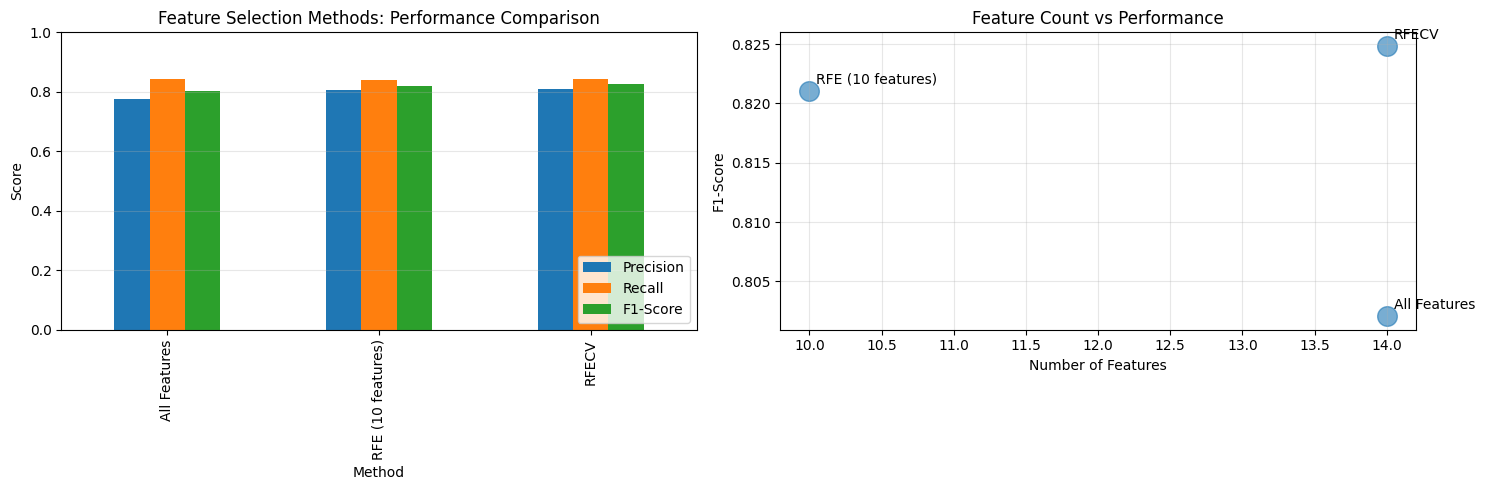

/nThe best LR Model only needed 10 features!
              precision    recall  f1-score   support

     Cooling       0.99      0.94      0.96      7236
     Heating       0.87      0.99      0.93      2229
     Neutral       0.57      0.60      0.59      1047

    accuracy                           0.91     10512
   macro avg       0.81      0.84      0.82     10512
weighted avg       0.92      0.91      0.92     10512



In [ ]:
print("\n" + "="*80)
print("FEATURE SELECTION COMPARISON")
print("="*80)

# training with all features for comparison
lr_all = LogisticRegression(
    C=0.1,
    solver='lbfgs',              # required for multinomial
    max_iter=1000,
    class_weight='balanced',           # baseline
    random_state=42)
lr_all.fit(X_train_smote, y_train_smote)
y_pred_all = lr_all.predict(X_test_scaled_gen)

# creating comparison DataFrame
feature_comparison = pd.DataFrame({
    'Method': ['All Features', 'RFE (10 features)', 'RFECV'],
    'Num Features': [X.shape[1], 10, rfecv.n_features_],
    'Accuracy': [
        accuracy_score(y_test, y_pred_all),
        accuracy_score(y_test, y_pred_rfe),
        accuracy_score(y_test, y_pred_rfecv)
    ],
    'Precision': [
        precision_score(y_test, y_pred_all, average='macro'),
        precision_score(y_test, y_pred_rfe, average='macro'),
        precision_score(y_test, y_pred_rfecv, average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_all, average='macro'),
        recall_score(y_test, y_pred_rfe, average='macro'),
        recall_score(y_test, y_pred_rfecv, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_all, average='macro'),
        f1_score(y_test, y_pred_rfe, average='macro'),
        f1_score(y_test, y_pred_rfecv, average='macro')
    ]
})

print(feature_comparison.to_string(index=False))

# Visualizing comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Performance comparison execution
feature_comparison.set_index('Method')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', ax=axes[0]
)
axes[0].set_title('Feature Selection Methods: Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Method')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# # of features vs F1-Score
axes[1].scatter(feature_comparison['Num Features'],
               feature_comparison['F1-Score'], s=200, alpha=0.6)
for i, method in enumerate(feature_comparison['Method']):
    axes[1].annotate(method,
                    (feature_comparison['Num Features'][i],
                     feature_comparison['F1-Score'][i]),
                    xytext=(5, 5), textcoords='offset points')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Feature Count vs Performance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('/nThe best LR Model only needed 10 features!')
print(classification_report(y_test, y_pred_rfecv))

The feature selection did little to improve the LR model base off the smote balancing, but the grid search along witht hese features will hopefully improve on metrics.

###8.4: Choosing Features for Decision Tree Model

In [ ]:
# Environmental Features
env_features = [
    'Environment:Site Outdoor Air Drybulb Temperature[C]',
    'Environment:Site Outdoor Air Wetbulb Temperature[C]',
]

# Internal Building Features
internal_load_features = [
    'InteriorLights:Electricity[J]',
    'InteriorEquipment:Electricity[J]',
]

# Indicators of Mechanical Performance Features
mechanical_features = [
    '21 ZONE PVAV 1 FAN:Fan Electric Power[W]',
    '21 ZONE PVAV 1 FAN:Fan Air Mass Flow Rate[kg/s]',
    'MAIN SERVICE WATER LOOP CIRCULATOR PUMP:Pump Electric Power[W]'
]

# Time Features
time_features = [
    'weekday'
]

features_upd = (env_features +
internal_load_features +
mechanical_features +
time_features)

X_dt_tuned = df[features_upd]
y = df['operational_mode']

The features that the tree model found unimportant were removed and will be retested with a potentially new max depth to improve performance.

###8.4: Hyperparameter Tuning For KNN(Loss and Convergence for KNN)

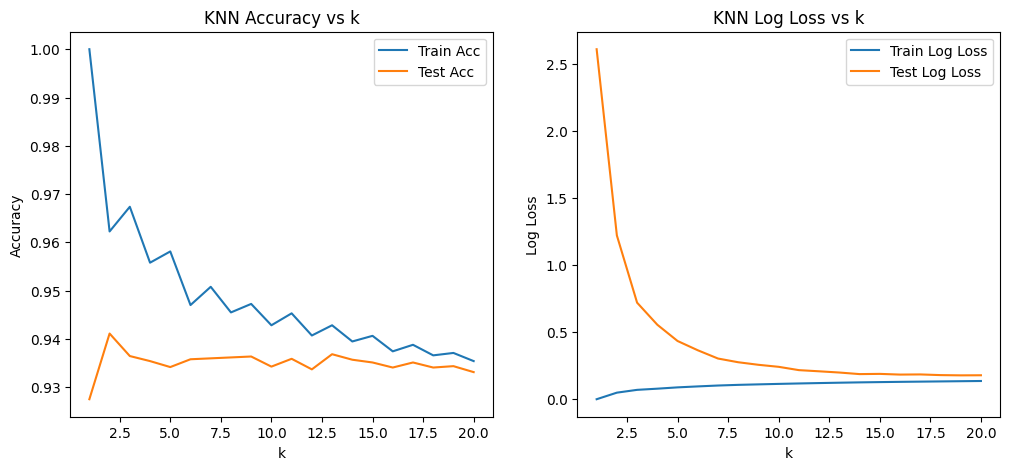

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, accuracy_score

k_values = range(1, 21)
train_acc_knn, test_acc_knn = [], []
train_loss_knn, test_loss_knn = [], []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled_gen, y_train)

    y_train_pred = knn.predict(X_train_scaled_gen)
    y_test_pred = knn.predict(X_test_scaled_gen)

    train_acc_knn.append(accuracy_score(y_train, y_train_pred))
    test_acc_knn.append(accuracy_score(y_test, y_test_pred))

    train_loss_knn.append(
        log_loss(y_train, knn.predict_proba(X_train_scaled_gen))
    )

    test_loss_knn.append(
        log_loss(y_test, knn.predict_proba(X_test_scaled_gen))
    )

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(k_values, train_acc_knn, label='Train Acc')
axes[0].plot(k_values, test_acc_knn, label='Test Acc')
axes[0].set_title('KNN Accuracy vs k')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(k_values, train_loss_knn, label='Train Log Loss')
axes[1].plot(k_values, test_loss_knn, label='Test Log Loss')
axes[1].set_title('KNN Log Loss vs k')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Log Loss')
axes[1].legend()

plt.show()


Here it is clear the after a certain value of k(about 8) the loss changes little and the test accuracy stays reasonably constant, which provide a good range to use for the grid search, in finding the best k value. In a range of about 3 to 13 for k, the model will be more genralizable to new data, while maintain accuracy and not overfitting.

###8.5: Grid Search for KNN

In [ ]:
from sklearn.model_selection import GridSearchCV

print("\n" + "="*80)
print("GRID SEARCH - K-NEAREST NEIGHBORS")
print("="*80)

# Defining the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print(f"\nParameter grid:")
for param, values in param_grid_knn.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations to try: {6 * 2 * 3} = 36")
print(f"With 5-fold CV: {36 * 5} = 180 model fits\n")

# creating KNN classifier
knn = KNeighborsClassifier()

# TODO: create GridSearchCV object with stratified k-fold scross validation k=5
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# TODO: fit grid search (this may take a minute)
print("Starting grid search...")
grid_search_knn.fit(X_train_rfe, y_train_smote)

# displaying the results
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS")
print(f"{'='*80}")
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_knn.best_score_:.4f}")

# evaluating on test set
best_knn = grid_search_knn.best_estimator_
y_pred_knn_tuned = best_knn.predict(X_test_rfe)

print(f"\nPerformance on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_knn_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn_tuned, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_knn_tuned, average='macro'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_knn_tuned, average='macro'):.4f}")

print(classification_report(y_test, y_pred_knn_tuned))


GRID SEARCH - K-NEAREST NEIGHBORS

Parameter grid:
  n_neighbors: [3, 5, 7, 9, 11, 13]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan', 'minkowski']

Total combinations to try: 36 = 36
With 5-fold CV: 180 = 180 model fits

Starting grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GRID SEARCH RESULTS
Best parameters: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Best cross-validation F1 score: 0.8964

Performance on Test Set:
Accuracy:  0.9494
Precision: 0.8829
Recall:    0.9066
F1-Score:  0.8940
              precision    recall  f1-score   support

     Cooling       0.99      0.97      0.98      7236
     Heating       0.93      0.94      0.94      2229
     Neutral       0.73      0.80      0.76      1047

    accuracy                           0.95     10512
   macro avg       0.88      0.91      0.89     10512
weighted avg       0.95      0.95      0.95     10512



After doing the grid search with the range of k's of 3-13 as mentioned previosuly the metrics in the neutral categories surpassed 0.7 and recall reached 0.8 which is close to as good in performance as the decision tree with less overfitting. The parameters used for this were as listed:

    'n_neighbors': [3, 5, 7, 9, 11, 13],

    'weights': ['uniform', 'distance'],
    
    'metric': ['euclidean', 'manhattan', 'minkowski']

###8.6: Loss and Convergence for LR

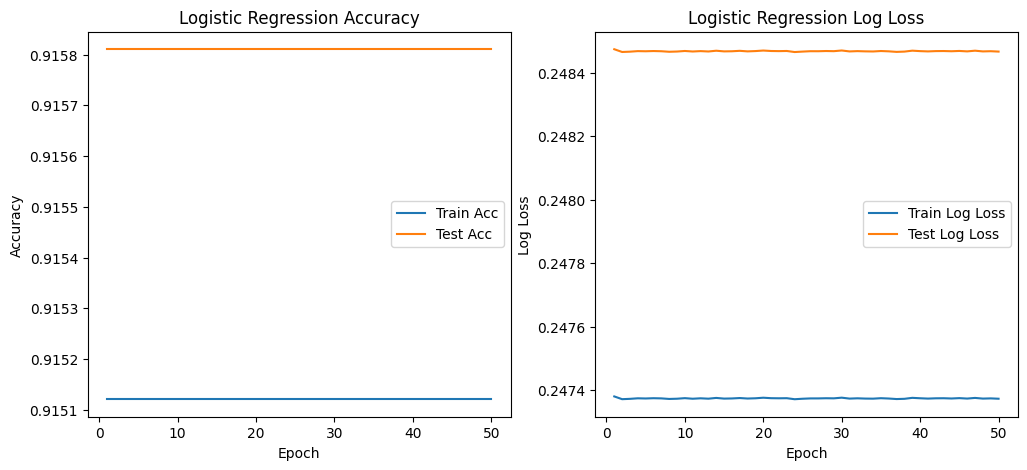

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score

# Logistic Regression via SGD
clf = SGDClassifier(loss='log_loss', max_iter=100, warm_start=True, random_state=42)
epochs = 50
train_acc, test_acc = [], []
train_loss, test_loss = [], []

for epoch in range(epochs):
    clf.fit(X_train_scaled_gen, y_train)
    y_train_prob = clf.predict_proba(X_train_scaled_gen)
    y_test_prob = clf.predict_proba(X_test_scaled_gen)

    train_loss.append(log_loss(y_train, y_train_prob))
    test_loss.append(log_loss(y_test, y_test_prob))

    train_acc.append(accuracy_score(y_train, clf.predict(X_train_scaled_gen)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test_scaled_gen)))

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy / convergence
axes[0].plot(range(1, epochs+1), train_acc, label='Train Acc')
axes[0].plot(range(1, epochs+1), test_acc, label='Test Acc')
axes[0].set_title('Logistic Regression Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Log loss
axes[1].plot(range(1, epochs+1), train_loss, label='Train Log Loss')
axes[1].plot(range(1, epochs+1), test_loss, label='Test Log Loss')
axes[1].set_title('Logistic Regression Log Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Log Loss')
axes[1].legend()

plt.show()


The log loss and accuracy for the LR model both did not change with increasing epochs, which demonstrates that increasing epoch will not help with neutral classification or accuracy.

###8.7: Grid Search for Logistic Regression


In [ ]:
print("\n" + "="*80)
print("GRID SEARCH - LOGISTIC REGRESSION")
print("="*80)

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],   # supports l1 + l2
    'class_weight': [None, 'balanced']
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# TODO: GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid_lr,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
# TODO: executing the grid search
print("Starting grid search...")
grid_search_lr.fit(X_train_rfe, y_train_smote)

# TODO: results
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS")
print(f"{'='*80}")
print(f"{'='*80}")
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_lr.best_score_:.4f}")

# evaluating on test set
best_lr = grid_search_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test_rfe)

print(f"\nPerformance on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr_tuned, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr_tuned, average='macro'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr_tuned, average='macro'):.4f}")

print(classification_report(y_test, y_pred_lr_tuned))


GRID SEARCH - LOGISTIC REGRESSION
Starting grid search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GRID SEARCH RESULTS
Best parameters: {'C': 100, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.8512

Performance on Test Set:
Accuracy:  0.9231
Precision: 0.8262
Recall:    0.8505
F1-Score:  0.8371
              precision    recall  f1-score   support

     Cooling       0.99      0.95      0.97      7236
     Heating       0.87      0.98      0.92      2229
     Neutral       0.62      0.62      0.62      1047

    accuracy                           0.92     10512
   macro avg       0.83      0.85      0.84     10512
weighted avg       0.93      0.92      0.92     10512



The metrics of the LR model did not increase from the smote spampling significantly, even after this grid search, whcih indicates there is either an underlying problem with class definition vagueness, the multiclass element of the class distribution, or the impact of outliers. These were the parameters used:

    'C': [0.001, 0.01, 0.1, 1, 10, 100],

    'penalty': ['l1', 'l2'],

    'solver': ['liblinear'],   # supports l1 + l2

    'class_weight': [None, 'balanced']

###8.8: Loss and Convergence for Decision Tree

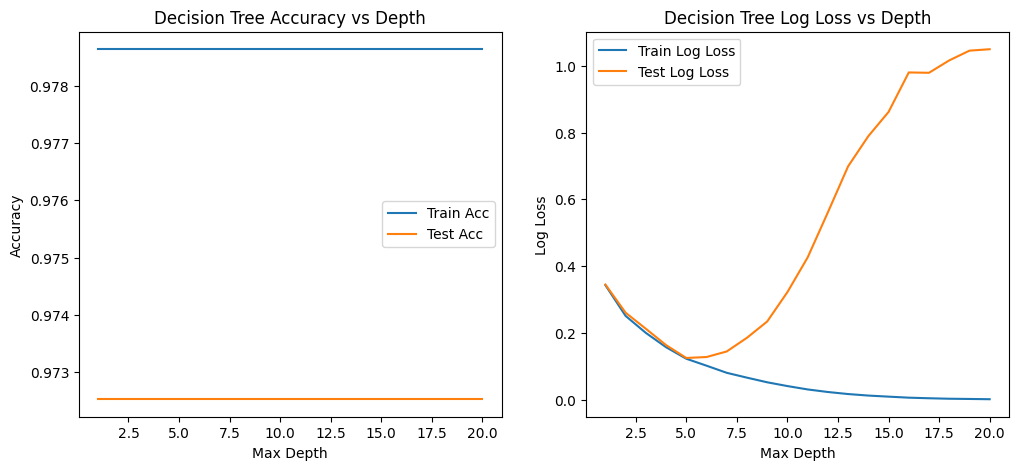

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, accuracy_score

depths = range(1, 21)
train_acc_dt, test_acc_dt = [], []
train_loss_dt, test_loss_dt = [], []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train_dt, y_train_dt)

    y_train_pred = dt.predict(X_train_dt)
    y_test_pred = dt.predict(X_test_dt)

    train_acc_dt.append(accuracy_score(y_train_dt, y_train_pred_dt))
    test_acc_dt.append(accuracy_score(y_test_dt, y_test_pred_dt))

    train_loss_dt.append(log_loss(y_train_dt, dt.predict_proba(X_train_dt)))
    test_loss_dt.append(log_loss(y_test_dt, dt.predict_proba(X_test_dt)))

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(depths, train_acc_dt, label='Train Acc')
axes[0].plot(depths, test_acc_dt, label='Test Acc')
axes[0].set_title('Decision Tree Accuracy vs Depth')
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(depths, train_loss_dt, label='Train Log Loss')
axes[1].plot(depths, test_loss_dt, label='Test Log Loss')
axes[1].set_title('Decision Tree Log Loss vs Depth')
axes[1].set_xlabel('Max Depth')
axes[1].set_ylabel('Log Loss')
axes[1].legend()

plt.show()


Here the accuracy does not change with depth of the tree but at around 5-7 the loss goes incrediblly high with more overfitting, and more of a chance to pick up noise.

###8.9: Balancing the Classes for Decision Tree and Changing Max Depth

In [ ]:
X_train_dt_tuned, X_test_dt_tuned, y_train_dt_tuned, y_test_dt_tuned = train_test_split(
    X_dt_tuned, y, stratify = y,
    test_size=0.25, random_state=101)

# Defining Decision Tree Object
dt = DecisionTreeClassifier(
    max_depth=7,           # Limit tree depth
    min_samples_split=20,   # Minimum samples to split a node
    min_samples_leaf=50,    # Minimum samples in a leaf
    random_state=42,
    class_weight='balanced'
)

# Training the model
dt.fit(X_train_dt_tuned, y_train_dt)

print("Model trained successfully!")
print(f"Number of classes: {dt.n_classes_}")
print(f"Classes: {dt.classes_}")

# Making predictions on both training and test sets
y_test_pred_dt_tuned = dt.predict(X_test_dt_tuned)
y_train_pred_dt_tuned = dt.predict(X_train_dt_tuned)

# Calculate and print metrics for training set
acc_test_dt = accuracy_score(y_test_dt_tuned, y_test_pred_dt_tuned)
f1_test_dt = f1_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
precision_dt_test = precision_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
recall_dt_test = recall_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')

print("Decision Tree Test Set Performance:")
print("="*60)
print(f"Accuracy:  {acc_test_dt:.3f} ({acc_test_dt*100:.2f}%)")
print("="*60)
print(f"F1-Score:  {f1_test_dt:.3f}")
print("="*60)
print(f"Precision:  {precision_dt_test:.3f}")
print("="*60)
print(f"Recall:  {recall_dt_test:.3f}")

print(classification_report(y_test_dt_tuned, y_test_pred_dt_tuned))


Model trained successfully!
Number of classes: 3
Classes: ['Cooling' 'Heating' 'Neutral']
Decision Tree Test Set Performance:
Accuracy:  0.950 (94.98%)
F1-Score:  0.907
Precision:  0.885
Recall:  0.941
              precision    recall  f1-score   support

     Cooling       1.00      0.95      0.97      9045
     Heating       0.97      0.95      0.96      2786
     Neutral       0.69      0.92      0.79      1309

    accuracy                           0.95     13140
   macro avg       0.88      0.94      0.91     13140
weighted avg       0.96      0.95      0.95     13140



Using the class weight balance and a max depth of 7, the trees precision for neutral classification does drop to 0.69, however, the recall increases to
0.93. This closes the gap between class recall, and makes the decision tree overfit less as well. I also increased minimum samples per leaf to decrease overfitting. The parameter use were as follows:

    max_depth=7,           # Limit tree depth

    min_samples_split=20,   # Minimum samples to split a node

    min_samples_leaf=10,    # Minimum samples in a leaf
    
    random_state=42,

    class_weight='balanced'

###8.10: K-Fold Cross-Validation on LR


K-FOLD CROSS-VALIDATION

5-Fold Cross-Validation Results:
F1 Scores for each fold: [0.84708671 0.84932088 0.84335094 0.85131308 0.84385081]
Mean F1 Score: 0.8470
Std F1 Score:  0.0031


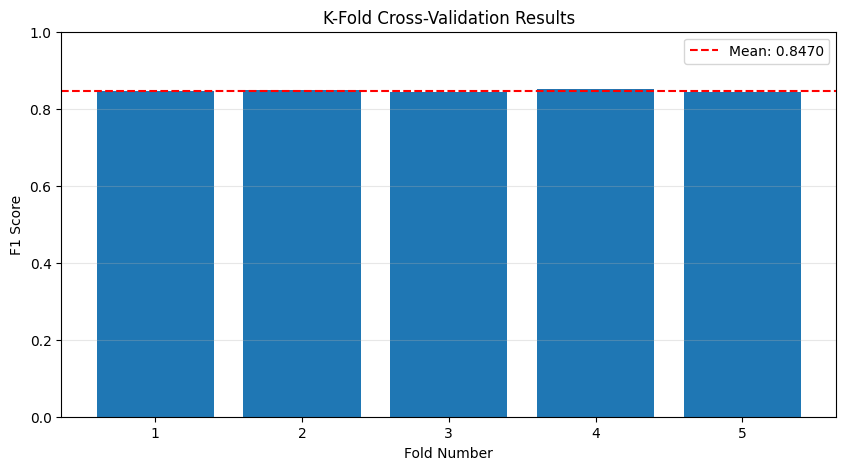

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

print("\n" + "="*80)
print("K-FOLD CROSS-VALIDATION")
print("="*80)

# logistic regression model object definition
lr = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# 5-Fold Cross-Validation implementation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold = cross_val_score(
    lr, X_train_smote, y_train_smote, cv=kfold, scoring='f1_macro'
)

print("\n5-Fold Cross-Validation Results:")
print(f"F1 Scores for each fold: {scores_kfold}")
print(f"Mean F1 Score: {scores_kfold.mean():.4f}")
print(f"Std F1 Score:  {scores_kfold.std():.4f}")

# Visualize fold results
plt.figure(figsize=(10, 5))
plt.bar(range(1, 6), scores_kfold)
plt.axhline(y=scores_kfold.mean(), color='r', linestyle='--',
           label=f'Mean: {scores_kfold.mean():.4f}')
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')
plt.title('K-Fold Cross-Validation Results')
plt.legend()
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.show()

###8.11: Stratified K-Fold Cross-Validation on LR

In [ ]:
from sklearn.model_selection import StratifiedKFold

print("\n" + "="*80)
print("STRATIFIED K-FOLD CROSS-VALIDATION")
print("="*80)

# Create StratifiedKFold object with 5 splits
skfold = StratifiedKFold(
      n_splits=5, shuffle=True, random_state=42
)
# Apply Stratified K-Fold CV
scores_skfold = cross_val_score(
    lr, X_train_smote, y_train_smote, cv=skfold, scoring='f1_macro'
    )

print("\nStratified 5-Fold Cross-Validation Results:")
print(f"F1 Scores for each fold: {scores_skfold}")
print(f"Mean F1 Score: {scores_skfold.mean():.4f}")
print(f"Std F1 Score:  {scores_skfold.std():.4f}")

# Compare K-Fold vs Stratified K-Fold
comparison = pd.DataFrame({
    'Method': ['K-Fold', 'Stratified K-Fold','Smote Split KNN', 'Smote Split LR'],
    'Mean F1': [scores_kfold.mean(), scores_skfold.mean(),
                f1_score(y_test, y_pred_smote_knn, average='macro'),
                f1_score(y_test, y_pred_smote_lr, average='macro')],
    'Std F1': [scores_kfold.std(), scores_skfold.std(), np.nan, np.nan]
})
print("\nComparison:")
print(comparison.to_string(index=False))


STRATIFIED K-FOLD CROSS-VALIDATION

Stratified 5-Fold Cross-Validation Results:
F1 Scores for each fold: [0.84838735 0.85118221 0.84378212 0.8448898  0.84662971]
Mean F1 Score: 0.8470
Std F1 Score:  0.0026

Comparison:
           Method  Mean F1   Std F1
           K-Fold 0.846984 0.003073
Stratified K-Fold 0.846974 0.002621
  Smote Split KNN 0.845080      NaN
   Smote Split LR 0.802074      NaN


This shows cross-validation vs single split. A single split depending on the split type, can either give very good returns or bad ones for the models. Cross Validations essentially looks at robustness of the model. If there is a low mean F1 or high high stdev, the model is not robust and result can depend highly on the split. For imbalanced data like this, statified k fold is even better to check for robustness, and the worst model, LR, received 0.84 F1 with little stdev, indicating the robustness of the LR model, despite its neutral classification issue, but also reinforces the performance of the other 2 more high performing models.

#9: Model Evaluation and Comparison

###9.1 Compare All Tuned Models (Plot)


COMPARISON OF TUNED MODELS
                      Model  Accuracy  Precision   Recall  F1-Score
                KNN (Tuned)  0.949391   0.882871 0.906567  0.894031
Logistic Regression (Tuned)  0.923135   0.826159 0.850535  0.837108
      Decision Tree (Tuned)  0.949848   0.884599 0.941451  0.907318


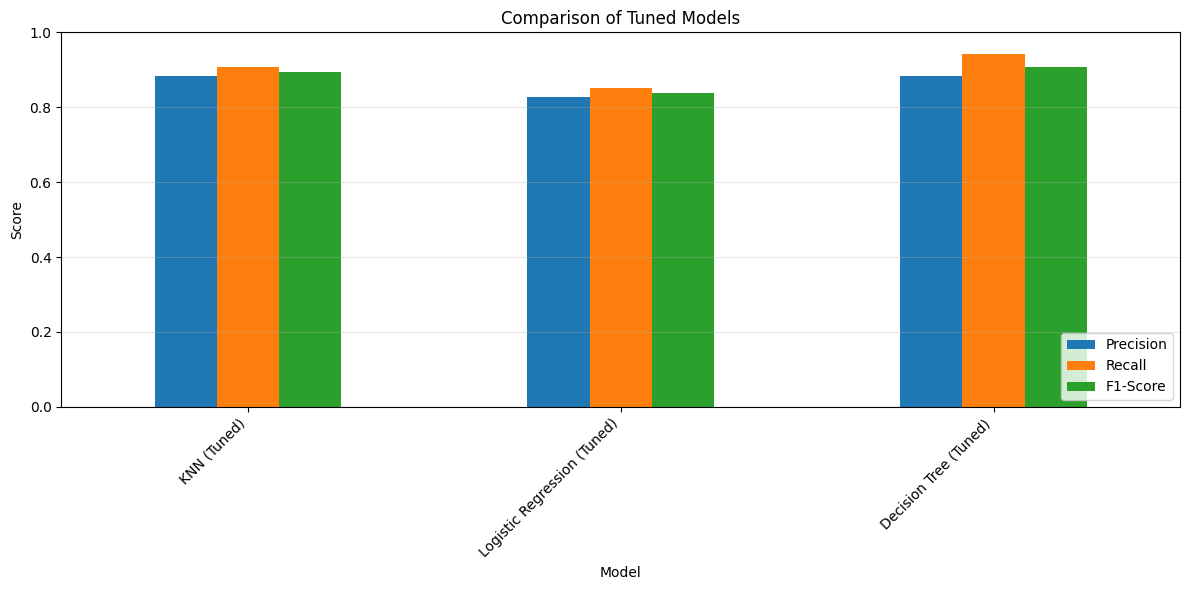


KNN Test Set Performance:
              precision    recall  f1-score   support

     Cooling       0.99      0.97      0.98      7236
     Heating       0.93      0.94      0.94      2229
     Neutral       0.73      0.80      0.76      1047

    accuracy                           0.95     10512
   macro avg       0.88      0.91      0.89     10512
weighted avg       0.95      0.95      0.95     10512


LR Test Set Performance:
              precision    recall  f1-score   support

     Cooling       0.99      0.95      0.97      7236
     Heating       0.87      0.98      0.92      2229
     Neutral       0.62      0.62      0.62      1047

    accuracy                           0.92     10512
   macro avg       0.83      0.85      0.84     10512
weighted avg       0.93      0.92      0.92     10512


Decision Tree Test Set Performance:
              precision    recall  f1-score   support

     Cooling       1.00      0.95      0.97      9045
     Heating       0.97      0.95      

In [ ]:
print("\n" + "="*80)
print("COMPARISON OF TUNED MODELS")
print("="*80)

# comparison DataFrame for evaluation metrics
tuned_comparison = pd.DataFrame({
    'Model': ['KNN (Tuned)', 'Logistic Regression (Tuned)', 'Decision Tree (Tuned)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn_tuned),
        accuracy_score(y_test, y_pred_lr_tuned),
        accuracy_score(y_test_dt_tuned, y_test_pred_dt_tuned)
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn_tuned, average='macro'),
        precision_score(y_test, y_pred_lr_tuned, average='macro'),
        precision_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn_tuned, average='macro'),
        recall_score(y_test, y_pred_lr_tuned, average='macro'),
        recall_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_knn_tuned, average='macro'),
        f1_score(y_test, y_pred_lr_tuned, average='macro'),
        f1_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
    ]
})

print(tuned_comparison.to_string(index=False))

# Visualize comparison
tuned_comparison.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6)
)
plt.title('Comparison of Tuned Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKNN Test Set Performance:")
print("="*60)
print(classification_report(y_test, y_pred_knn_tuned))
print("="*60)

print("\nLR Test Set Performance:")
print("="*60)
print(classification_report(y_test, y_pred_lr_tuned))
print("="*60)


print("\nDecision Tree Test Set Performance:")
print("="*60)
print(classification_report(y_test_dt_tuned, y_test_pred_dt_tuned))
print("="*60)



###9.2: LR Comparison to Baseline


BASELINE VS OPTIMIZED PIPELINE COMPARISON
                      Model  Accuracy  Precision   Recall  F1-Score
Baseline (No preprocessing)  0.928843   0.857683 0.793133  0.809512
         Optimized Pipeline  0.923135   0.826159 0.850535  0.837108


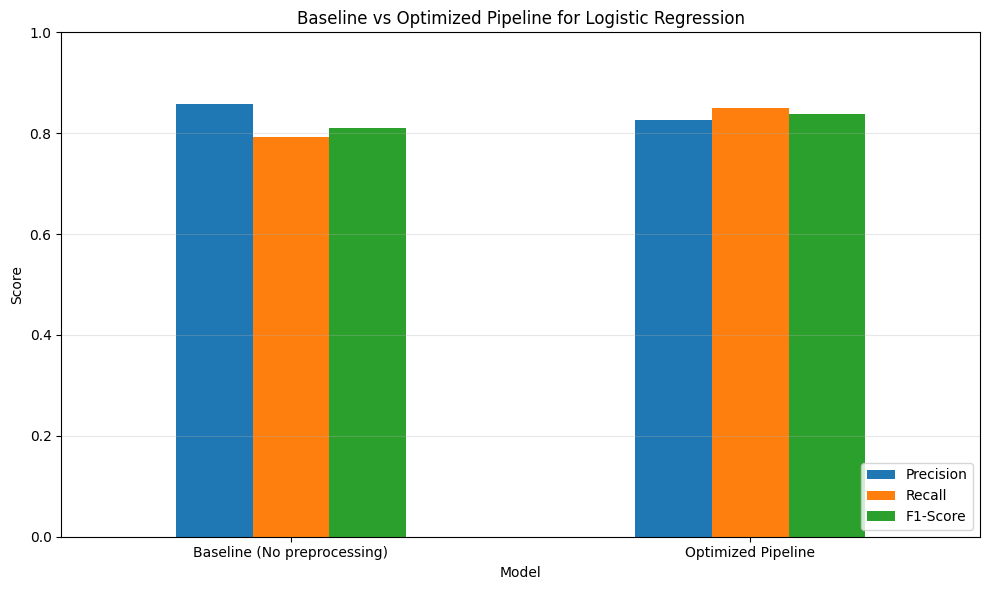

Confusion Matrices (Test Sets):
[[7113    1  126]
 [   5 2240   26]
 [ 296  294  411]]
[[6865    6  365]
 [   6 2189   34]
 [  79  318  650]]


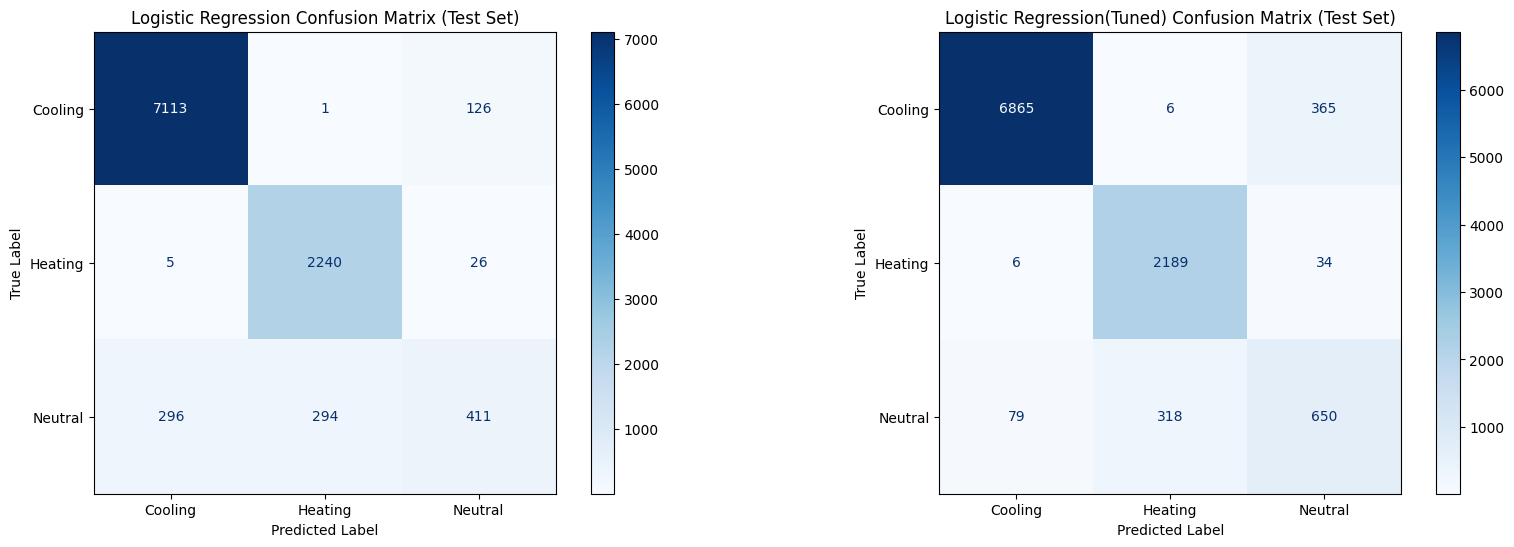

In [ ]:
# Train baseline model for comparison (no preprocessing)
print("\n" + "="*80)
print("BASELINE VS OPTIMIZED PIPELINE COMPARISON")
print("="*80)

# Create comparison
pipeline_comparison = pd.DataFrame({
    'Model': ['Baseline (No preprocessing)', 'Optimized Pipeline'],
    'Accuracy': [
        accuracy_score(y_test_lr, y_test_pred_lr),
        accuracy_score(y_test, y_pred_lr_tuned)
    ],
    'Precision': [
        precision_score(y_test_lr, y_test_pred_lr, average='macro'),
        precision_score(y_test, y_pred_lr_tuned, average='macro')
    ],
    'Recall': [
        recall_score(y_test_lr, y_test_pred_lr, average='macro'),
        recall_score(y_test, y_pred_lr_tuned, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test_lr, y_test_pred_lr, average='macro'),
        f1_score(y_test, y_pred_lr_tuned, average='macro')
    ]
})

print(pipeline_comparison.to_string(index=False))

# Visualize
pipeline_comparison.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6)
)
plt.title('Baseline vs Optimized Pipeline for Logistic Regression')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting the Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

cm_lr_test = confusion_matrix(y_test_lr, y_test_pred_lr)
cm_lr_test_tuned = confusion_matrix(y_test, y_pred_lr_tuned)

# Display confusion matrix for Logistic Regression test sets
disp_lr_test = ConfusionMatrixDisplay(cm_lr_test, display_labels = dt.classes_)
disp_lr_test.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Logistic Regression Confusion Matrix (Test Set)')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.grid(False)

disp_lr_test_tuned = ConfusionMatrixDisplay(cm_lr_test_tuned, display_labels = dt.classes_)
disp_lr_test_tuned.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('Logistic Regression(Tuned) Confusion Matrix (Test Set)')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.grid(False)

print("Confusion Matrices (Test Sets):")
print(cm_lr_test)
print(cm_lr_test_tuned)


###9.3: KNN Comparison to Baseline


BASELINE VS OPTIMIZED PIPELINE COMPARISON
                      Model  Accuracy  Precision   Recall  F1-Score
Baseline (No preprocessing)  0.931126   0.860837 0.828980  0.841470
         Optimized Pipeline  0.949391   0.882871 0.906567  0.894031


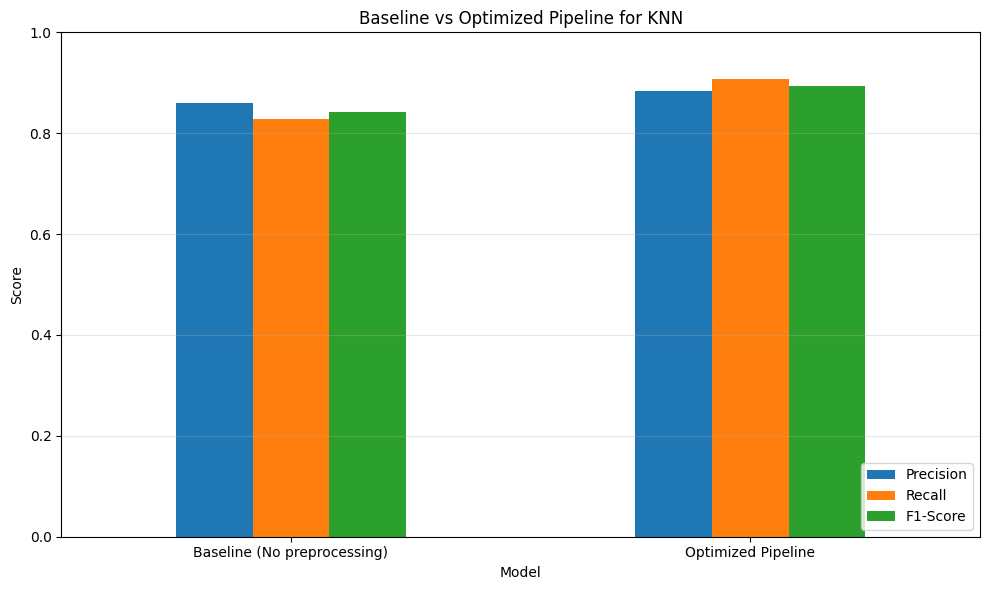

Confusion Matrices (Test Sets):
[[10599     4   252]
 [    3  3227   113]
 [  445   269   856]]
[[7034    8  194]
 [   2 2105  122]
 [  55  151  841]]


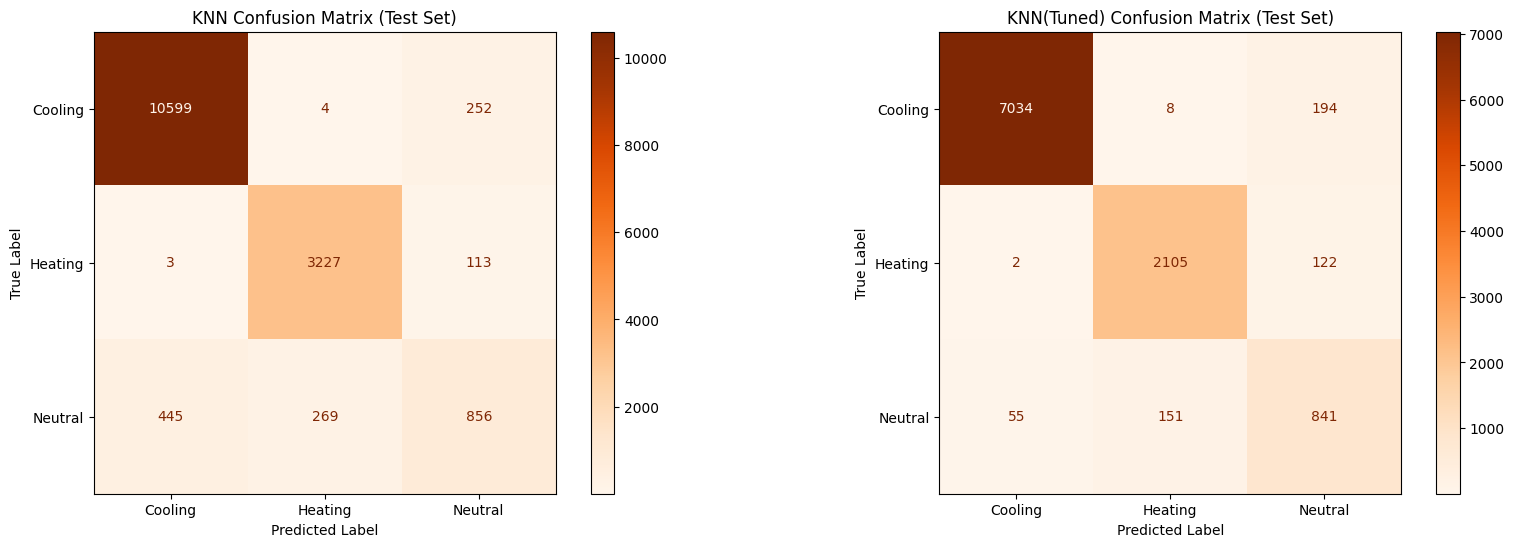

In [ ]:
# Train baseline model for comparison (no preprocessing)
print("\n" + "="*80)
print("BASELINE VS OPTIMIZED PIPELINE COMPARISON")
print("="*80)

# Create comparison
pipeline_comparison = pd.DataFrame({
    'Model': ['Baseline (No preprocessing)', 'Optimized Pipeline'],
    'Accuracy': [
        accuracy_score(y_test_knn, y_test_pred_knn),
        accuracy_score(y_test, y_pred_knn_tuned)
    ],
    'Precision': [
        precision_score(y_test_knn, y_test_pred_knn, average='macro'),
        precision_score(y_test, y_pred_knn_tuned, average='macro')
    ],
    'Recall': [
        recall_score(y_test_knn, y_test_pred_knn, average='macro'),
        recall_score(y_test, y_pred_knn_tuned, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test_knn, y_test_pred_knn, average='macro'),
        f1_score(y_test, y_pred_knn_tuned, average='macro')
    ]
})

print(pipeline_comparison.to_string(index=False))

# Visualize
pipeline_comparison.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6)
)
plt.title('Baseline vs Optimized Pipeline for KNN')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
cm_knn_test = confusion_matrix(y_test_knn, y_test_pred_knn)
cm_knn_test_tuned = confusion_matrix(y_test, y_pred_knn_tuned)

# Display confusion matrix for KNN test sets
disp_knn_test = ConfusionMatrixDisplay(cm_knn_test, display_labels = dt.classes_)
disp_knn_test.plot(ax=ax1, cmap='Oranges', values_format='d')
ax1.set_title('KNN Confusion Matrix (Test Set)')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.grid(False)

disp_knn_test_tuned = ConfusionMatrixDisplay(cm_knn_test_tuned, display_labels = dt.classes_)
disp_knn_test_tuned.plot(ax=ax2, cmap='Oranges', values_format='d')
ax2.set_title('KNN(Tuned) Confusion Matrix (Test Set)')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.grid(False)

print("Confusion Matrices (Test Sets):")
print(cm_knn_test)
print(cm_knn_test_tuned)





###9.4: Decision Tree Comparison to Baseline


BASELINE VS OPTIMIZED PIPELINE COMPARISON
                      Model  Accuracy  Precision   Recall  F1-Score
Baseline (No preprocessing)  0.972527   0.945842 0.933013  0.938867
         Optimized Pipeline  0.949848   0.884599 0.941451  0.907318


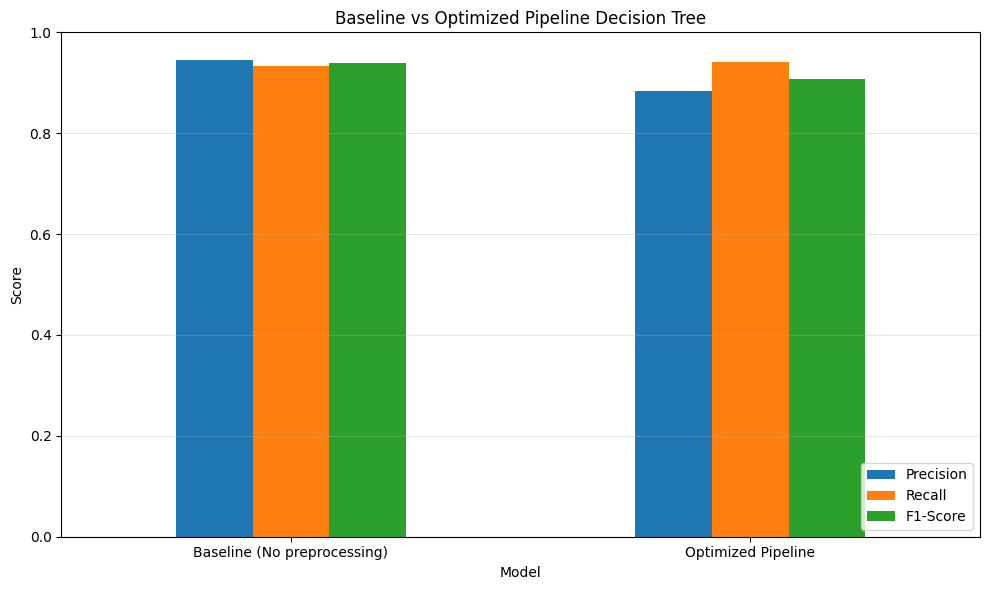

Confusion Matrices (Test Sets):
[[8959    1   85]
 [   5 2740   41]
 [  95  134 1080]]
[[8627    6  412]
 [   2 2651  133]
 [  27   79 1203]]


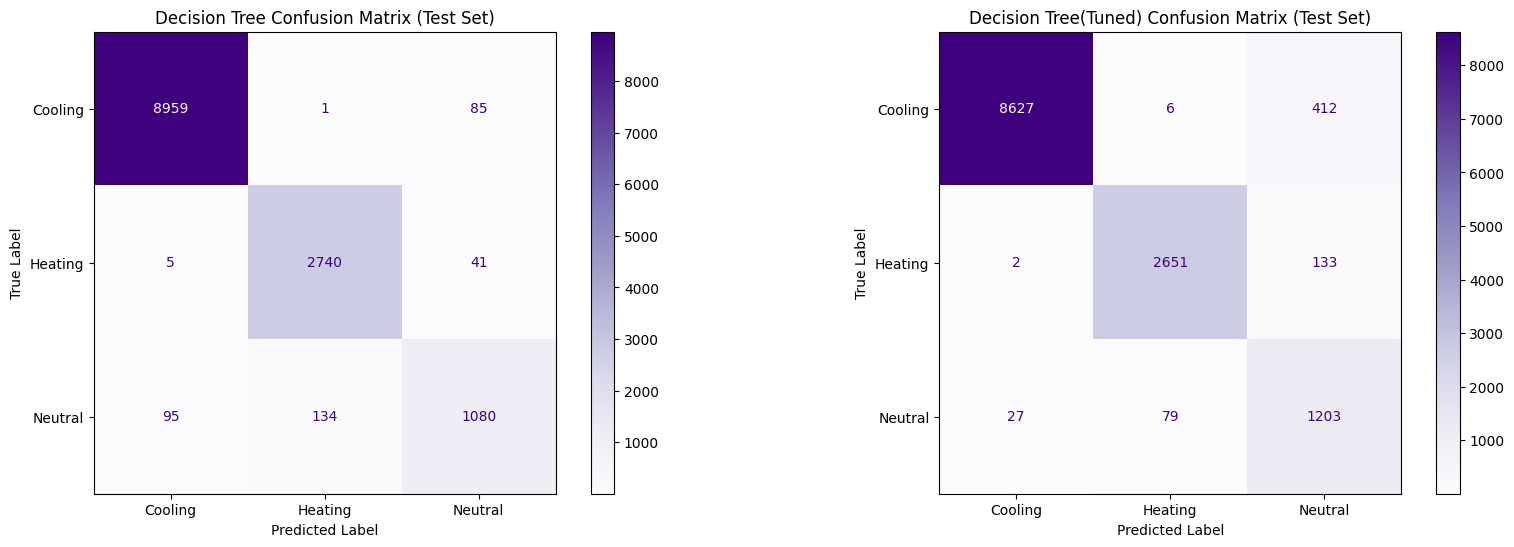

In [ ]:
# Train baseline model for comparison (no preprocessing)
print("\n" + "="*80)
print("BASELINE VS OPTIMIZED PIPELINE COMPARISON")
print("="*80)

# Create comparison
pipeline_comparison = pd.DataFrame({
    'Model': ['Baseline (No preprocessing)', 'Optimized Pipeline'],
    'Accuracy': [
        accuracy_score(y_test_dt, y_test_pred_dt),
        accuracy_score(y_test_dt_tuned, y_test_pred_dt_tuned)
    ],
    'Precision': [
        precision_score(y_test_dt, y_test_pred_dt, average='macro'),
        precision_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
    ],
    'Recall': [
        recall_score(y_test_dt, y_test_pred_dt, average='macro'),
        recall_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
    ],
    'F1-Score': [
        f1_score(y_test_dt, y_test_pred_dt, average='macro'),
        f1_score(y_test_dt_tuned, y_test_pred_dt_tuned, average='macro')
    ]
})

print(pipeline_comparison.to_string(index=False))

# Visualize
pipeline_comparison.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6)
)
plt.title('Baseline vs Optimized Pipeline Decision Tree')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

cm_dt_test = confusion_matrix(y_test_dt, y_test_pred_dt)
cm_dt_test_tuned = confusion_matrix(y_test_dt_tuned, y_test_pred_dt_tuned)

# Display confusion matrix for decision tree test set
disp_dt_test = ConfusionMatrixDisplay(cm_dt_test, display_labels = dt.classes_)
disp_dt_test.plot(ax=ax1, cmap='Purples', values_format='d')
ax1.set_title('Decision Tree Confusion Matrix (Test Set)')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.grid(False)

disp_dt_test_tuned = ConfusionMatrixDisplay(cm_dt_test_tuned, display_labels = dt.classes_)
disp_dt_test_tuned.plot(ax=ax2, cmap='Purples', values_format='d')
ax2.set_title('Decision Tree(Tuned) Confusion Matrix (Test Set)')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.grid(False)

print("Confusion Matrices (Test Sets):")
print(cm_dt_test)
print(cm_dt_test_tuned)


#10: Results and Discussion

My models tell me that classifying a neutral mode in a multiclass problem is very difficult especially compared to compared to a binary, heat vs cooling mode classification. Neutral classification is somewhat an 'other' target class, when the mode is not heating or cooling.


The features that were most important were the fan energy, the envrionmental temperatures, as well as the interior equipment electricity used. The patterns in misclassification were most commonly with the neutral class do to with the loose definition of the operational mode. Therefore, the metircs for LR and KNN before the data balancing and tuning was good for macros but poor for neutral classification. For pre-tuned decision tree the neutral classification was well above my expectations for this project of 0.8 metrics or better but there was some overfitting.


To account for these issues I balanced the data with SMOTE for LR and KNN but NOT for decision tree since I didn't want to mess around with what worked for the tree. I made class weights for LR and Decision tree balanced to acocunt for the imbalance. I also removed the features the decision tree did not need to decrease dimensionality. I also did feature selection for LR and applied the selection to KNN as well.


I also did loss and convergence plots to determine the appropriate k values for KNN, max depth for decision tree. I used this range of k values in a Grid search to find the best combination for KNN, and I also did Grid search on LR to do the same. THe KNN improved significantly around to where the baseline decision tree was which I felt was a win for this project with metrics approaching 0.8. This is an appropriate goal with these models and situation as it is not as severe consequences as something such as medical diagnosis or products, but is rather looking for a rough estimate operational mode indicator.
THe decision tree baseline and tuned both performed well for different situations, as it became a trade off between very good recall and precision.


This analysis is limited by the plausibility of the class and definition and size of the neutral classs compared to the other classes. The main challenges I encountered were not in the macro and general averages but in the classification report classifcation metrics. Getting the neutral metrics to improve in the KNN took scaling, SMOTE, loss and convergence analysis, and Grid Search which is time exhaustive. THe LR, going through the same process did not improve to a desire 0.75-0.8 metric cutoff whcih demonstrates the difficulty associated with the classification problem. I would not use LR if I could do this again, as I feel a more advanced and suitable algorithm would have done better than the LR and maybe even the decision tree.


I think a better and more optimized version this could be applied to the real world if optimized better and "AI BMS" systems are somewhat starting to be implemented and can defintely be used to help with stopping energy inefficiency.


In practice, this model could serve as a real-time operational mode indicator in Building Management Systems (BMS), helping facility managers identify when HVAC systems are in heating, cooling, or neutral modes. Deployment would require integration with energy and environmental sensors, real-time data preprocessing, and robust handling of missing or noisy data. Potential risks include incorrect classification leading to misinterpretation of system efficiency, which could result in unnecessary interventions or false assumptions about energy usage. Ethical considerations involve transparency in automated decision-making and ensuring the system does not replace human oversight, particularly in critical or high-energy-use facilities.


Additional data such as more granular occupancy patterns, humidity levels, or historical system logs could improve model accuracy, especially for the neutral class. Incorporating time-series features or leveraging models capable of capturing temporal dependencies, such as LSTM or other sequence-based models, may perform better than LR or KNN. Ensemble methods like Random Forests or Gradient Boosting could also provide a more robust alternative to Decision Trees. Finally, exploring semi-supervised learning or anomaly detection techniques could help better characterize ambiguous operational modes, ultimately improving classification reliability in real-world BMS deployments.



#11:References

Miller, C., et al. The Building Energy Dataset: A large-scale synthetic dataset of building operation. Nature Scientific Data.

Dataset: Building Energy Dataset. Available at: https://doi.org/10.1038/s41597-023-01971-5

Smith, J., et al. (2023).

scikit-learn documentation: https://scikit-learn.org/